### Imports

In [2]:
# filter all the warnings
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import xgboost as xgb
import lightgbm as lgb
from optuna import Trial
from sklearn.metrics import f1_score
import torch
from pytorch_tabnet.tab_model import TabNetClassifier
import joblib

import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, random_split
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.offline as pyo
import plotly.express as px
pyo.init_notebook_mode()

from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold, cross_val_score

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from collections import Counter

import optuna

import shap
shap.initjs()

from pprint import pprint
from joblib import dump
from tqdm import tqdm
from typing import Union, Callable, Tuple, List
import os



In [3]:
data = pd.read_csv('encoded_dataset.csv')
data.columns

Index(['Unnamed: 0', 'Patient Number', 'Age', 'Clarity', 'Color',
       'Transparency', 'Spec Gravity', 'pH Level', 'Leukocytes', 'Nitrite',
       'Protein', 'Glucose', 'Ketones', 'Urobilinogen', 'Bilirubin', 'Blood',
       'Bacteria', 'Epithelial Cells', 'RBC', 'WBC', 'Mucus Threads',
       'Amorphous Urate/Phosphate', 'DIAGNOSIS', 'Marital Status_MARRIED',
       'Marital Status_SINGLE', 'Marital Status_WIDOW', 'FEMALE', 'FILIPINO'],
      dtype='object')

In [4]:
columns_to_modify = ['Marital Status_MARRIED', 'Marital Status_SINGLE', 
                     'Marital Status_WIDOW', 'FEMALE', 'FILIPINO']

data[columns_to_modify] = data[columns_to_modify].replace({True: 1, False: 0})


### Data Splitting


In [5]:
X = data.drop(columns=['DIAGNOSIS', 'Unnamed: 0'])  
y = data['DIAGNOSIS']

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [7]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

### Scaling of Features

In [8]:
columns_to_scale = ['Age', 'pH Level', 'Spec Gravity', 'Urobilinogen']  

preprocessor = ColumnTransformer(
    transformers=[
        ('scaler', StandardScaler(), columns_to_scale)
    ],
    remainder='passthrough'  
)

In [9]:
X_train_scaled = preprocessor.fit_transform(X_train)

X_val_scaled = preprocessor.transform(X_val)
X_test_scaled = preprocessor.transform(X_test)

# Integration purposes
joblib.dump(preprocessor, 'scaler.pkl')
print("Scaler saved as 'scaler.pkl'")

Scaler saved as 'scaler.pkl'


In [10]:
X_scaled_df = pd.DataFrame(X_train_scaled, columns=X.columns)

# Integration purposes
column_order = X_scaled_df.columns.tolist()
joblib.dump(column_order, 'column_order.pkl')
print("Column order saved as 'column_order.pkl'")


Column order saved as 'column_order.pkl'


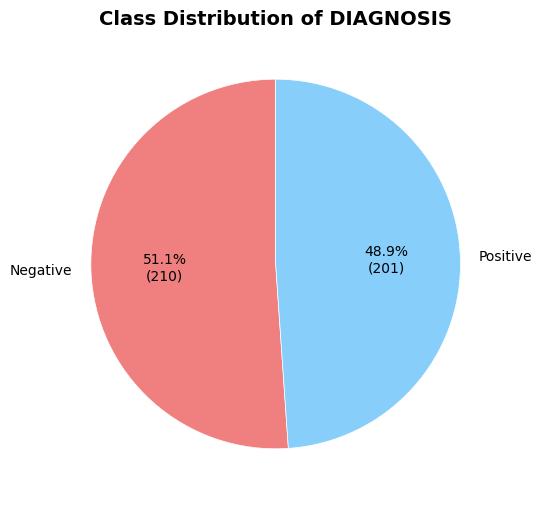

In [11]:
class_counts = y.value_counts()
labels = ['Negative', 'Positive']

def autopct_format(values):
    def inner_autopct(pct):
        total = sum(values)
        count = int(round(pct * total / 100.0))
        return f'{pct:.1f}%\n({count:d})'
    return inner_autopct

plt.figure(figsize=(6, 6))
plt.pie(class_counts, labels=labels, autopct=autopct_format(class_counts), startangle=90, 
        colors=['lightcoral', 'lightskyblue'], wedgeprops={'linewidth': 0.5, 'edgecolor': 'white'})

plt.title('Class Distribution of DIAGNOSIS', fontsize=14, fontweight='bold')

plt.show()

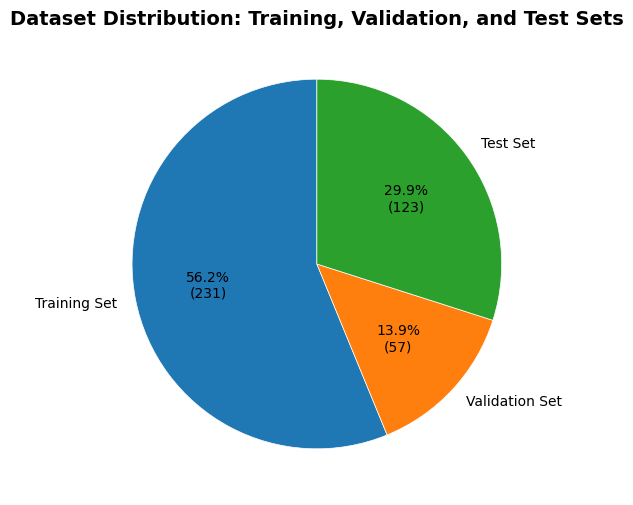

In [12]:
total_records = 411

test_percentage = 0.3
validation_percentage = 0.2

test_count = int(total_records * test_percentage)
train_val_count = total_records - test_count
validation_count = int(train_val_count * validation_percentage)
train_count = train_val_count - validation_count

subset_counts = [train_count, validation_count, test_count]
labels = ['Training Set', 'Validation Set', 'Test Set']

def autopct_format(values):
    def inner_autopct(pct):
        total = sum(values)
        count = int(round(pct * total / 100.0))
        return f'{pct:.1f}%\n({count:d})'
    return inner_autopct

colors = plt.cm.tab10.colors[:3]  
plt.figure(figsize=(6, 6))
plt.pie(subset_counts, labels=labels, autopct=autopct_format(subset_counts), startangle=90,
        colors=colors, wedgeprops={'linewidth': 0.5, 'edgecolor': 'white'})

plt.title('Dataset Distribution: Training, Validation, and Test Sets', fontsize=14, fontweight='bold')
plt.show()


In [13]:
X.columns

Index(['Patient Number', 'Age', 'Clarity', 'Color', 'Transparency',
       'Spec Gravity', 'pH Level', 'Leukocytes', 'Nitrite', 'Protein',
       'Glucose', 'Ketones', 'Urobilinogen', 'Bilirubin', 'Blood', 'Bacteria',
       'Epithelial Cells', 'RBC', 'WBC', 'Mucus Threads',
       'Amorphous Urate/Phosphate', 'Marital Status_MARRIED',
       'Marital Status_SINGLE', 'Marital Status_WIDOW', 'FEMALE', 'FILIPINO'],
      dtype='object')

In [14]:
def show_study_summary(study: optuna.study.Study) -> None:
    print("\033[1mBest Hyperparameters")
    pprint(study.best_params)
    print()

    print("\033[1mAccuracy for the Best Hyperparameters")
    print(study.best_value)

    optimization_history_plot = optuna.visualization.plot_optimization_history(study)
    param_importances_plot = optuna.visualization.plot_param_importances(study)


    optimization_history_plot.update_layout({"height": 600})
    param_importances_plot.update_layout({"height": 600})


    optimization_history_plot.show()
    param_importances_plot.show()


## Logistic Regression

In [15]:
def logreg_objective(trial: optuna.study.Study) -> float:
    PARAMS = {
        "tol": trial.suggest_float("tol", 1e-6, 1e-2, log=True),
        "C": trial.suggest_float("C", 0.1, 1),
    }

    LOGREG = LogisticRegression(**PARAMS, max_iter=2000, random_state=42)

    LOGREG.fit(X_train_scaled , y_train)

    THRESHOLD = trial.suggest_float('threshold', 0.1, 1)

    YHAT = [1 if proba[1] > THRESHOLD else 0 for proba in LOGREG.predict_proba(X_val_scaled )]

    F1_SCORE_ = f1_score(y_val , YHAT)

    return F1_SCORE_

SEED = 42  
SAMPLER = optuna.samplers.TPESampler(seed=SEED)


LOGREG_STUDY = optuna.create_study(direction="maximize", study_name="logreg_tuning", sampler=SAMPLER)

LOGREG_STUDY.optimize(logreg_objective, n_trials=200, n_jobs=-1, show_progress_bar=True)

[I 2024-12-26 21:44:02,617] A new study created in memory with name: logreg_tuning


  0%|          | 0/200 [00:00<?, ?it/s]

[I 2024-12-26 21:44:02,804] Trial 4 finished with value: 0.9354838709677419 and parameters: {'tol': 0.005279471230327798, 'C': 0.2639188882039042, 'threshold': 0.2267603288563017}. Best is trial 4 with value: 0.9354838709677419.
[I 2024-12-26 21:44:03,116] Trial 7 finished with value: 0.9354838709677419 and parameters: {'tol': 0.00036314837056362914, 'C': 0.49636568176752394, 'threshold': 0.158523427770677}. Best is trial 4 with value: 0.9354838709677419.
[I 2024-12-26 21:44:03,136] Trial 2 finished with value: 0.9655172413793104 and parameters: {'tol': 2.7373855842424382e-05, 'C': 0.1764404094941029, 'threshold': 0.46679716811375593}. Best is trial 2 with value: 0.9655172413793104.
[I 2024-12-26 21:44:03,152] Trial 0 finished with value: 0.9090909090909091 and parameters: {'tol': 4.493415355074694e-05, 'C': 0.579971940096745, 'threshold': 0.7812397772589561}. Best is trial 2 with value: 0.9655172413793104.
[I 2024-12-26 21:44:03,183] Trial 8 finished with value: 0.9354838709677419 and

In [16]:
show_study_summary(LOGREG_STUDY)

Best Hyperparameters
{'C': 0.5739658038691652,
 'threshold': 0.2843491621704455,
 'tol': 2.7032877709478827e-06}

Accuracy for the Best Hyperparameters
0.9830508474576272


## Support Vector Machine

In [17]:
def SVC_objective(trial: optuna.study.Study) -> float:
    PARAMS = {
        "C": trial.suggest_float("C", 0.1, 10, log=True),
        "kernel": trial.suggest_categorical("kernel", ["linear", "poly", "rbf", "sigmoid"])
    }

    SVC_MODEL = SVC(**PARAMS, probability=True, random_state=42)

    SVC_MODEL.fit(X_train_scaled, y_train)

    YHAT = SVC_MODEL.predict(X_val_scaled)

    F1_SCORE_ = f1_score(y_val, YHAT)

    return F1_SCORE_

SEED = 42  
SAMPLER = optuna.samplers.TPESampler(seed=SEED)

SVM_SVC_STUDY = optuna.create_study(direction="maximize", study_name="SVM_tuning", sampler=SAMPLER)

SVM_SVC_STUDY.optimize(SVC_objective, n_trials=200, n_jobs=-1, show_progress_bar=True)

[I 2024-12-26 21:44:22,554] A new study created in memory with name: SVM_tuning


  0%|          | 0/200 [00:00<?, ?it/s]

[I 2024-12-26 21:44:22,593] Trial 1 finished with value: 0.43636363636363634 and parameters: {'C': 8.710399027213194, 'kernel': 'sigmoid'}. Best is trial 1 with value: 0.43636363636363634.
[I 2024-12-26 21:44:22,630] Trial 0 finished with value: 0.6363636363636364 and parameters: {'C': 1.380995174135512, 'kernel': 'rbf'}. Best is trial 0 with value: 0.6363636363636364.
[I 2024-12-26 21:44:22,641] Trial 2 finished with value: 0.6268656716417911 and parameters: {'C': 0.2529466218474042, 'kernel': 'rbf'}. Best is trial 0 with value: 0.6363636363636364.
[I 2024-12-26 21:44:22,642] Trial 3 finished with value: 0.6666666666666666 and parameters: {'C': 0.1327548966436997, 'kernel': 'poly'}. Best is trial 3 with value: 0.6666666666666666.
[I 2024-12-26 21:44:22,660] Trial 6 finished with value: 0.6666666666666666 and parameters: {'C': 0.7590750868576748, 'kernel': 'poly'}. Best is trial 3 with value: 0.6666666666666666.
[I 2024-12-26 21:44:22,663] Trial 7 finished with value: 0.656716417910447

In [18]:
show_study_summary(SVM_SVC_STUDY)

Best Hyperparameters
{'C': 0.5997716284263526, 'kernel': 'linear'}

Accuracy for the Best Hyperparameters
0.9655172413793104


## XGBoost


In [19]:
def XGB_objective(trial: optuna.study.Study) -> float:

    PARAMS = {
        "objective": "binary:logistic",
        "booster": "gbtree",
        "reg_alpha": trial.suggest_float("reg_alpha", 0.1, 0.9),
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000, step=50),
        "max_depth": trial.suggest_int("max_depth", 3, 15),
        "learning_rate": trial.suggest_float("learning_rate", 0.0001, 0.1, log=True),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0)
    }

    XGB_model = xgb.XGBClassifier(**PARAMS, random_state=42)

    XGB_model.fit(X_train, y_train)

    YHAT = XGB_model.predict(X_val)

    F1_SCORE_ = f1_score(y_val, YHAT)

    return F1_SCORE_

SEED = 42  
SAMPLER = optuna.samplers.TPESampler(seed=SEED)

XGB_STUDY = optuna.create_study(direction="maximize", study_name="XGB_tuning", sampler=SAMPLER)

XGB_STUDY.optimize(XGB_objective, n_trials=200, n_jobs=-1, show_progress_bar=True)

[I 2024-12-26 21:45:54,307] A new study created in memory with name: XGB_tuning


  0%|          | 0/200 [00:00<?, ?it/s]

[I 2024-12-26 21:45:55,008] Trial 4 finished with value: 0.9375 and parameters: {'reg_alpha': 0.5637366499384854, 'n_estimators': 100, 'max_depth': 14, 'learning_rate': 0.0003698567104587303, 'subsample': 0.7837883295392172, 'colsample_bytree': 0.8215645138350337}. Best is trial 4 with value: 0.9375.
[I 2024-12-26 21:45:55,162] Trial 3 finished with value: 0.8450704225352113 and parameters: {'reg_alpha': 0.5532079210904652, 'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.0001431341105623361, 'subsample': 0.74842538417827, 'colsample_bytree': 0.9726051976753671}. Best is trial 4 with value: 0.9375.
[I 2024-12-26 21:45:55,481] Trial 1 finished with value: 0.9830508474576272 and parameters: {'reg_alpha': 0.13902872603070382, 'n_estimators': 250, 'max_depth': 15, 'learning_rate': 0.0027706460666011962, 'subsample': 0.773617255644348, 'colsample_bytree': 0.6703034360777274}. Best is trial 1 with value: 0.9830508474576272.
[I 2024-12-26 21:45:55,644] Trial 0 finished with value: 0.98

In [20]:
show_study_summary(XGB_STUDY)

Best Hyperparameters
{'colsample_bytree': 0.6703034360777274,
 'learning_rate': 0.0027706460666011962,
 'max_depth': 15,
 'n_estimators': 250,
 'reg_alpha': 0.13902872603070382,
 'subsample': 0.773617255644348}

Accuracy for the Best Hyperparameters
0.9830508474576272


## LGBM

In [21]:
def lightgbm_objective(trial: optuna.study.Study) -> float:

    PARAMS = {
        "data_sample_strategy": "goss",
        "verbosity": -1,
        "boosting_type": trial.suggest_categorical("boosting_type", ["gbdt", "dart"]),
        "num_leaves": trial.suggest_int('num_leaves', 10, 200, step=10),
        "n_estimators": trial.suggest_int("n_estimators", 100, 500, step=50),
        "max_depth": trial.suggest_categorical("max_depth", [-1, 3, 4, 5]),
        "learning_rate": trial.suggest_float("learning_rate", 0.0001, 0.1, log=True),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.1, 0.9),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100)
    }
    
    LGMB_MODEL = lgb.LGBMClassifier(**PARAMS, random_state=42)
    
    LGMB_MODEL.fit(X_train, y_train) 
    
    YHAT = LGMB_MODEL.predict(X_val)
    
    F1_SCORE_ = f1_score(y_val, YHAT)
    
    return F1_SCORE_

SEED = 42  
SAMPLER = optuna.samplers.TPESampler(seed=SEED)

LGBM_STUDY = optuna.create_study(direction="maximize", study_name="lgbm_tuning", sampler=SAMPLER)

LGBM_STUDY.optimize(lightgbm_objective, n_trials=200, n_jobs=-1, show_progress_bar=True)

[I 2024-12-26 21:46:43,630] A new study created in memory with name: lgbm_tuning


  0%|          | 0/200 [00:00<?, ?it/s]

[I 2024-12-26 21:46:43,966] Trial 2 finished with value: 0.15873015873015872 and parameters: {'boosting_type': 'dart', 'num_leaves': 190, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.09269712533339358, 'reg_alpha': 0.6135477498210485, 'subsample': 0.9635465066112301, 'colsample_bytree': 0.5424105559222834, 'min_child_samples': 88}. Best is trial 2 with value: 0.15873015873015872.
[I 2024-12-26 21:46:43,996] Trial 4 finished with value: 0.7692307692307693 and parameters: {'boosting_type': 'dart', 'num_leaves': 200, 'n_estimators': 100, 'max_depth': 4, 'learning_rate': 0.003125105030878344, 'reg_alpha': 0.595996474700811, 'subsample': 0.7582569610388312, 'colsample_bytree': 0.8020249712150551, 'min_child_samples': 97}. Best is trial 4 with value: 0.7692307692307693.
[I 2024-12-26 21:46:44,047] Trial 5 finished with value: 0.8253968253968254 and parameters: {'boosting_type': 'dart', 'num_leaves': 80, 'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.022010375151332612, 'r

In [22]:
show_study_summary(LGBM_STUDY)

Best Hyperparameters
{'boosting_type': 'dart',
 'colsample_bytree': 0.8284336409602936,
 'learning_rate': 0.0015137238210515248,
 'max_depth': 5,
 'min_child_samples': 15,
 'n_estimators': 450,
 'num_leaves': 100,
 'reg_alpha': 0.5983698661611707,
 'subsample': 0.7269877935729978}

Accuracy for the Best Hyperparameters
0.9836065573770492


## TabNet

In [23]:
# TabNet preprocessing
X_train_np = X_train.values
X_val_np = X_val.values
X_test_np = X_test.values
y_train_np = y_train.values
y_val_np = y_val.values
y_test_np = y_test.values

In [24]:
numerical_columns = X.select_dtypes(include=['float64', 'int64']).columns
numerical_indices = [X.columns.get_loc(col) for col in numerical_columns]

tab_scaler = StandardScaler()

X_train_np[:, numerical_indices] = tab_scaler.fit_transform(X_train_np[:, numerical_indices])

X_val_np[:, numerical_indices] = tab_scaler.transform(X_val_np[:, numerical_indices])
X_test_np[:, numerical_indices] = tab_scaler.transform(X_test_np[:, numerical_indices])

In [25]:
def tabnet_objective(trial: optuna.study.Study) -> float:
    n_d = trial.suggest_int("n_d", 8, 32, step=8)
    n_a = trial.suggest_int("n_a", 8, 32, step=8)
    n_steps = trial.suggest_int("n_steps", 3, 6)
    gamma = trial.suggest_float("gamma", 1.0, 1.5, step=0.1)
    lambda_sparse = trial.suggest_float("lambda_sparse", 1e-5, 1e-2, log=True)
    lr = trial.suggest_float("lr", 1e-3, 5e-2, log=True)
    batch_size = trial.suggest_int("batch_size", 256, 1024, step=128)

    tabnet_model = TabNetClassifier(
        n_d=n_d, n_a=n_a, n_steps=n_steps, gamma=gamma,
        lambda_sparse=lambda_sparse, optimizer_params=dict(lr=lr), seed=42
    )

    tabnet_model.fit(
        X_train=X_train_np, 
        y_train=y_train_np,
        eval_set=[(X_train_np, y_train_np), (X_val_np, y_val_np)],
        eval_name=["train", "val"],
        eval_metric=["accuracy"],  
        max_epochs=100,
        patience=5,
        batch_size=batch_size,
        virtual_batch_size=batch_size // 2,
        num_workers=0,
        drop_last=False,
    )

    YHAT = tabnet_model.predict(X_val_np)
    f1 = recall_score(y_val_np, YHAT)
    return f1 

tabnet_study = optuna.create_study(direction="maximize", study_name="tabnet_tuning")
tabnet_study.optimize(tabnet_objective, n_trials=100, show_progress_bar=True)


[I 2024-12-26 21:47:10,843] A new study created in memory with name: tabnet_tuning


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 0  | loss: 1.85037 | train_accuracy: 0.47162 | val_accuracy: 0.5     |  0:00:00s
epoch 1  | loss: 1.61838 | train_accuracy: 0.49345 | val_accuracy: 0.5     |  0:00:00s
epoch 2  | loss: 1.48159 | train_accuracy: 0.47598 | val_accuracy: 0.5     |  0:00:00s
epoch 3  | loss: 1.2787  | train_accuracy: 0.51965 | val_accuracy: 0.48276 |  0:00:00s
epoch 4  | loss: 1.203   | train_accuracy: 0.55459 | val_accuracy: 0.56897 |  0:00:00s
epoch 5  | loss: 1.14075 | train_accuracy: 0.56332 | val_accuracy: 0.58621 |  0:00:00s
epoch 6  | loss: 1.01941 | train_accuracy: 0.56332 | val_accuracy: 0.62069 |  0:00:00s
epoch 7  | loss: 0.92693 | train_accuracy: 0.58952 | val_accuracy: 0.56897 |  0:00:00s
epoch 8  | loss: 0.91811 | train_accuracy: 0.59389 | val_accuracy: 0.60345 |  0:00:00s
epoch 9  | loss: 0.77914 | train_accuracy: 0.61135 | val_accuracy: 0.63793 |  0:00:00s
epoch 10 | loss: 0.70715 | train_accuracy: 0.61135 | val_accuracy: 0.65517 |  0:00:00s
epoch 11 | loss: 0.63228 | train_accuracy: 

In [26]:
show_study_summary(tabnet_study)

Best Hyperparameters
{'batch_size': 512,
 'gamma': 1.5,
 'lambda_sparse': 0.00024892739796483255,
 'lr': 0.0018661772001141088,
 'n_a': 16,
 'n_d': 32,
 'n_steps': 6}

Accuracy for the Best Hyperparameters
1.0


In [27]:
def test_model(
        models: list,
        params: dict,
        X_train: Union[np.ndarray, pd.DataFrame],
        y_train: Union[np.ndarray, pd.Series],
        X_test: Union[np.ndarray, pd.DataFrame],
        y_test: Union[np.ndarray, pd.Series],
        X_train_scaled: Union[np.ndarray, pd.DataFrame],
        X_test_scaled: Union[np.ndarray, pd.DataFrame]
    ) -> Tuple[dict, pd.DataFrame]:

    model_testing_scores = pd.DataFrame()
    models_container = {}

    model_testing_scores["Model"] = []
    model_testing_scores["Accuracy"] = []
    model_testing_scores["Precision"] = []
    model_testing_scores["Recall"] = []
    model_testing_scores["F1-Score"] = []
    model_testing_scores["Specificity"] = []
    model_testing_scores["AUC-ROC"] = []

    for model in tqdm(models):
        MODEL_NAME = model().__class__.__name__
        MODEL_KEY = MODEL_NAME + "_R" if (MODEL_NAME + "_R") in params else MODEL_NAME

        # Decide which data to use (scaled or unscaled)
        if MODEL_KEY in ["XGBClassifier", "LGBMClassifier"]:
            X_train_input, X_test_input = X_train, X_test  # Use unscaled data
        else:
            X_train_input, X_test_input = X_train_scaled, X_test_scaled  # Use scaled data

        # Check if model is Logistic Regression with a threshold
        if MODEL_KEY == "LogisticRegression_R" or MODEL_KEY == "LogisticRegression":
            test_model = model(tol=params[MODEL_KEY]["tol"],
                               C=params[MODEL_KEY]["C"],
                               max_iter=2000)
            test_model.fit(X_train_input, y_train)

            # Apply custom threshold
            test_pred = [1 if proba[1] > params[MODEL_KEY]["threshold"] else 0 for proba in
                         test_model.predict_proba(X_test_input)]

        # For all other models
        else:
            test_model = model(**params[MODEL_KEY])
            test_model.fit(X_train_input, y_train)
            test_pred = test_model.predict(X_test_input)

        TN, FP, _, _ = confusion_matrix(y_test, test_pred).ravel()
        TESTING_SPECIFICITY = TN / (TN + FP)

        model_testing_scores = model_testing_scores._append({
            "Model": MODEL_KEY,
            "Accuracy": accuracy_score(y_test, test_pred),
            "Precision": precision_score(y_test, test_pred),
            "Recall": recall_score(y_test, test_pred),
            "F1-Score": f1_score(y_test, test_pred),
            "Specificity": TESTING_SPECIFICITY,
            "AUC-ROC": roc_auc_score(y_test, test_pred)
        }, ignore_index=True)

        models_container[MODEL_KEY] = test_model

    return models_container, model_testing_scores


In [28]:
# TabNet Retraining

tabnet_model = TabNetClassifier(
    n_d=16,
    n_a=8,
    n_steps=4,
    gamma=1.5,
    lambda_sparse=0.0007733197217403411,
    optimizer_params=dict(lr=0.0339481484472662),
    seed=42
)

tabnet_model.fit(
    X_train=X_train_np, y_train=y_train_np,
    eval_set=[(X_train_np, y_train_np), (X_val_np, y_val_np)],
    eval_name=["train", "val"],
    eval_metric=["accuracy"],
    max_epochs=300,
    patience=15,
    batch_size=384,
    virtual_batch_size=384 // 2,
    num_workers=0,
    drop_last=False,
)

epoch 0  | loss: 1.25927 | train_accuracy: 0.52838 | val_accuracy: 0.53448 |  0:00:00s
epoch 1  | loss: 0.7514  | train_accuracy: 0.51092 | val_accuracy: 0.62069 |  0:00:00s
epoch 2  | loss: 0.58493 | train_accuracy: 0.52402 | val_accuracy: 0.56897 |  0:00:00s
epoch 3  | loss: 0.60266 | train_accuracy: 0.61135 | val_accuracy: 0.58621 |  0:00:00s
epoch 4  | loss: 0.51122 | train_accuracy: 0.73362 | val_accuracy: 0.62069 |  0:00:00s
epoch 5  | loss: 0.48489 | train_accuracy: 0.73362 | val_accuracy: 0.72414 |  0:00:00s
epoch 6  | loss: 0.40201 | train_accuracy: 0.75109 | val_accuracy: 0.74138 |  0:00:00s
epoch 7  | loss: 0.36645 | train_accuracy: 0.75546 | val_accuracy: 0.7931  |  0:00:00s
epoch 8  | loss: 0.38489 | train_accuracy: 0.81223 | val_accuracy: 0.82759 |  0:00:00s
epoch 9  | loss: 0.34298 | train_accuracy: 0.79913 | val_accuracy: 0.86207 |  0:00:00s
epoch 10 | loss: 0.3539  | train_accuracy: 0.81223 | val_accuracy: 0.82759 |  0:00:00s
epoch 11 | loss: 0.30427 | train_accuracy: 

In [29]:
tab_test_pred = tabnet_model.predict(X_test_np)

tab_test_scores = pd.DataFrame(columns=[
    "Model", "Accuracy", "Precision", "Recall", "F1-Score", "Specificity", "AUC-ROC"
])

TN, FP, FN, TP = confusion_matrix(y_test_np, tab_test_pred).ravel()
TESTING_SPECIFICITY = TN / (TN + FP)

tab_test_scores = tab_test_scores._append({
    "Model": "TabNetClassifier",
    "Accuracy": accuracy_score(y_test_np, tab_test_pred),
    "Precision": precision_score(y_test_np, tab_test_pred),
    "Recall": recall_score(y_test_np, tab_test_pred),
    "F1-Score": f1_score(y_test_np, tab_test_pred),
    "Specificity": TESTING_SPECIFICITY,
    "AUC-ROC": roc_auc_score(y_test_np, tab_test_pred)
}, ignore_index=True)

tab_test_scores

Model  Accuracy  Precision    Recall  F1-Score  Specificity  \
0  TabNetClassifier   0.91129   0.893939  0.936508  0.914729     0.885246   

    AUC-ROC  
0  0.910877

### Retraining Models

In [30]:
LIST_OF_MODELS = [LogisticRegression, SVC, xgb.XGBClassifier, lgb.LGBMClassifier]

MODELS_PARAMETERS = {
    "LogisticRegression": {
    'C': 0.4453875363488851,
    'threshold': 0.22236207331992044,
    'tol': 0.00013402013597938053


    },
    "SVC": {
        'C': 1.5539518731748816, 'kernel': 'linear', 'probability': True
    },
    "XGBClassifier": {      
      'colsample_bytree': 0.8185893721460695,
        'learning_rate': 0.02058418254468569,
        'max_depth': 14,
        'n_estimators': 450,
        'reg_alpha': 0.7174529376089127,
        'subsample': 0.523767606850942

    },
    "LGBMClassifier": {
        "data_sample_strategy": "goss",
        "verbosity": -1,
        'boosting_type': 'gbdt',
        'colsample_bytree': 0.6071597962768204,
        'learning_rate': 0.013343809558952492,
        'max_depth': 5,
        'min_child_samples': 62,
        'n_estimators': 100,
        'num_leaves': 200,
        'reg_alpha': 0.37118443370713083,
        'subsample': 0.8535933255065027
    }
}

MODEL_CONTAINER, TESTING_SCORES = test_model(
    models=LIST_OF_MODELS,
    params=MODELS_PARAMETERS,
    X_train=X_train,  # Unscaled
    y_train=y_train,
    X_test=X_test,  # Unscaled
    y_test=y_test,
    X_train_scaled=X_train_scaled,  # Scaled
    X_test_scaled=X_test_scaled  # Scaled
)

TESTING_SCORES

100%|██████████| 4/4 [00:02<00:00,  1.38it/s]


Model  Accuracy  Precision    Recall  F1-Score  Specificity  \
0  LogisticRegression  0.943548   0.911765  0.984127  0.946565     0.901639   
1                 SVC  0.935484   0.936508  0.936508  0.936508     0.934426   
2       XGBClassifier  0.967742   0.953846  0.984127  0.968750     0.950820   
3      LGBMClassifier  0.927419   0.935484  0.920635  0.928000     0.934426   

    AUC-ROC  
0  0.942883  
1  0.935467  
2  0.967473  
3  0.927531

In [31]:
MODEL_CONTAINER["TabNetClassifier"] = tabnet_model

### Full Models: Confusion Matrices 

In [32]:
def display_confusion_matrices(model_container, X_test, X_test_scaled, X_test_np, y_test, threshold=0.5):
    for name, model in model_container.items():
        if "XGB" in name or "LGBM" in name:
            X_input = X_test  
        elif "TabNet" in name:
            X_input = X_test_np
        else:
            X_input = X_test_scaled  

        # Make predictions with threshold for Logistic Regression
        if "LogisticRegression" in name:
            # Get probabilities and apply threshold
            y_pred = (model.predict_proba(X_input)[:, 1] >= threshold).astype(int)
        else:
            # Default prediction method for other models
            y_pred = model.predict(X_input)

        cm = confusion_matrix(y_test, y_pred)

        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
        plt.title(f"Confusion Matrix for {name}")
        plt.xlabel("Predicited Label")
        plt.ylabel("True Label")
        plt.show()


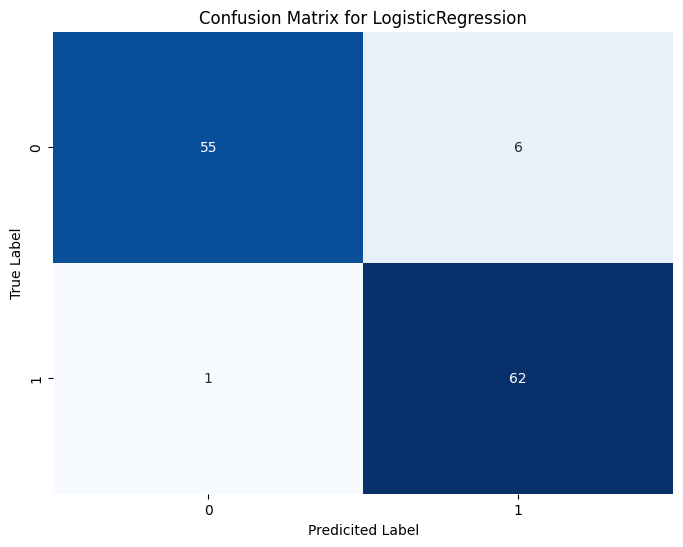

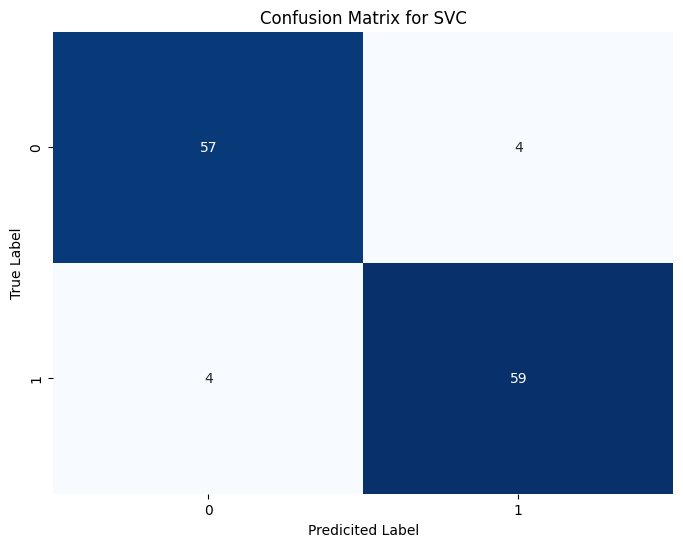

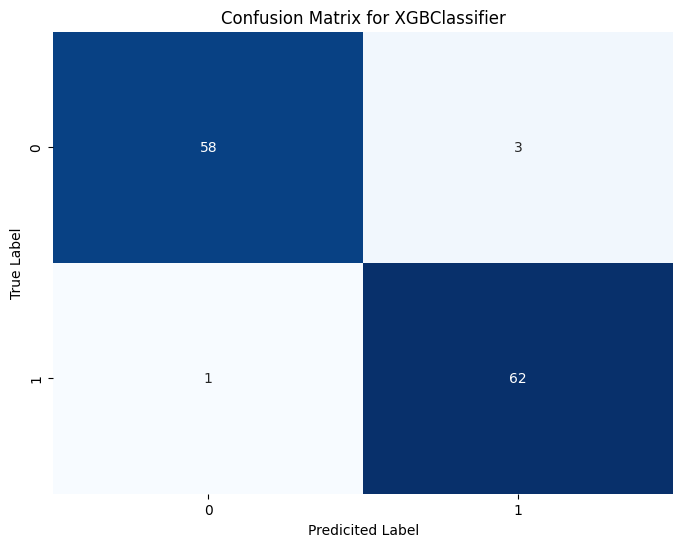

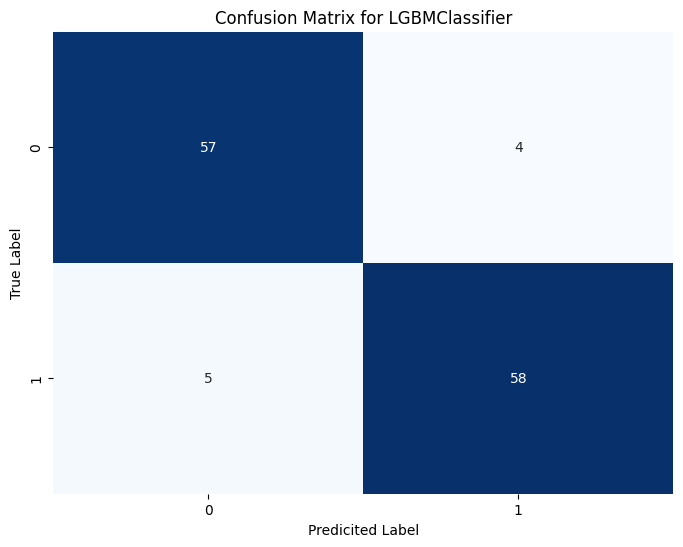

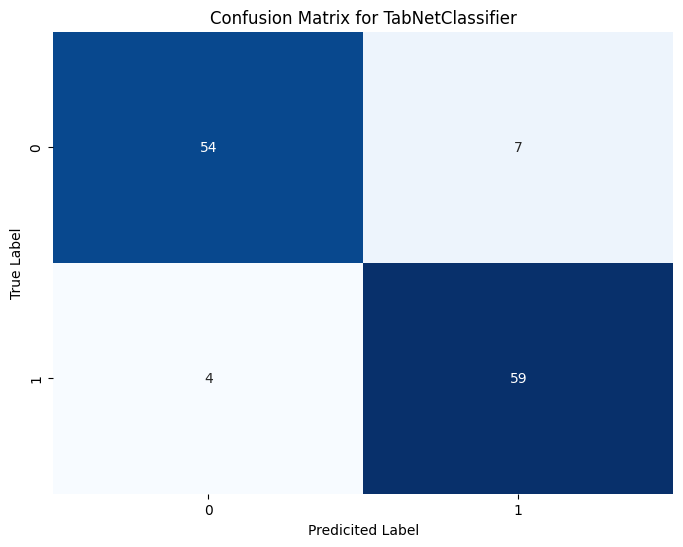

In [33]:
display_confusion_matrices(MODEL_CONTAINER, X_test, X_test_scaled, X_test_np, y_test, threshold=0.22236207331992044)

In [34]:
TESTING_SCORES = TESTING_SCORES._append(tab_test_scores, ignore_index=True)
TESTING_SCORES

Model  Accuracy  Precision    Recall  F1-Score  Specificity  \
0  LogisticRegression  0.943548   0.911765  0.984127  0.946565     0.901639   
1                 SVC  0.935484   0.936508  0.936508  0.936508     0.934426   
2       XGBClassifier  0.967742   0.953846  0.984127  0.968750     0.950820   
3      LGBMClassifier  0.927419   0.935484  0.920635  0.928000     0.934426   
4    TabNetClassifier  0.911290   0.893939  0.936508  0.914729     0.885246   

    AUC-ROC  
0  0.942883  
1  0.935467  
2  0.967473  
3  0.927531  
4  0.910877

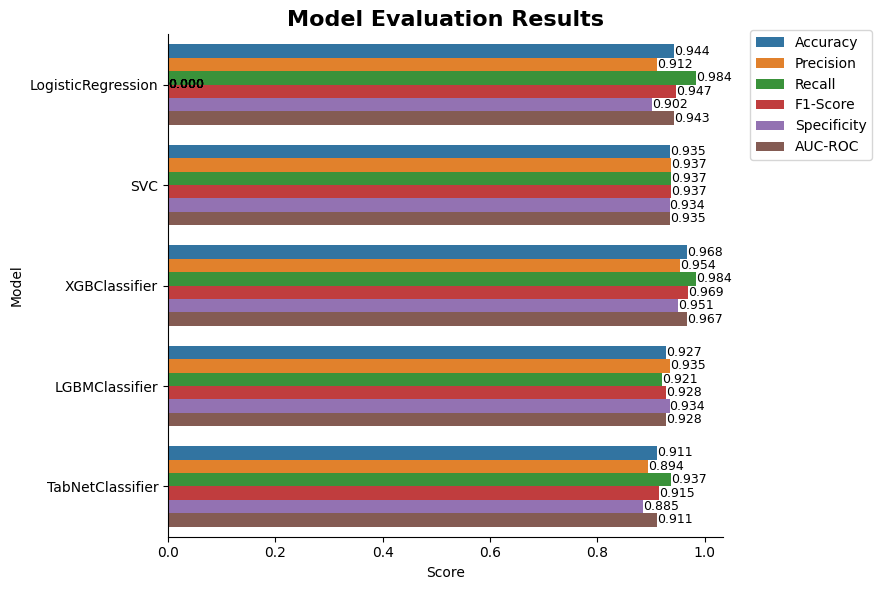

In [35]:
plot_df = pd.melt(TESTING_SCORES, id_vars=["Model"])
plot_df.rename({"variable": "Metric", "value": "Score"}, axis=1, inplace=True)

PLOT = sns.catplot(
    x="Score", 
    y="Model", 
    hue="Metric", 
    data=plot_df, 
    kind="bar", 
    orient="h",
    height=6, 
    aspect=1.5, 
    legend_out=False,
    palette="tab10"  
)

ax = PLOT.axes[0, 0]

for p in ax.patches:
    ax.annotate(f"{p.get_width():.3f}", 
                (p.get_x() + p.get_width(), p.get_y() + p.get_height() / 2),
                ha="left", va="center", fontsize=9)

plt.title("Model Evaluation Results", fontsize=16, fontweight='bold')
plt.legend(loc=(1.05, 0.75))
plt.tight_layout()

plt.show()

In [36]:
def plot_feature_importances(model, X_columns, title, top_n=20):

    # Extract and sort feature importances
    results = {column: value for value, column in zip(model.feature_importances_, X_columns)}
    sorted_results = sorted(results.items(), key=lambda x: x[1], reverse=True)[:top_n]  # Top N features

    # Separate names and values for the top features
    feature_names, importances = zip(*sorted_results)

    plt.figure(figsize=(14, 8))  
    plt.barh(range(len(importances)), importances, align='center', color="lightblue")
    plt.yticks(range(len(feature_names)), [name[:15] + '...' if len(name) > 15 else name for name in feature_names], fontsize=9)

    # Set titles and labels
    plt.title(f"{title}: Top {top_n} Feature Importance", fontsize=14, fontweight='bold')
    plt.xlabel("Feature importance", fontsize=12)
    plt.ylabel("Feature", fontsize=12)
    plt.ylim(-1, top_n)
    plt.gca().invert_yaxis()  
    plt.show()



In [37]:
TRAINED_XGB = MODEL_CONTAINER["XGBClassifier"]
TRAINED_LGBM = MODEL_CONTAINER["LGBMClassifier"]
TRAINED_SVM = MODEL_CONTAINER["SVC"]
TRAINED_LOGREG = MODEL_CONTAINER["LogisticRegression"]
TRAINED_TABNET = MODEL_CONTAINER["TabNetClassifier"]

In [38]:
y_pred_logreg = TRAINED_LOGREG.predict(X_test_scaled)

## FEATURE IMPORTANCE AND SHAP

In [39]:
import matplotlib.pyplot as plt

def plot_model_feature_importance(model, feature_names):

    feature_importances = model.feature_importances_
    
    sorted_indices = feature_importances.argsort()[::-1]
    sorted_feature_importances = feature_importances[sorted_indices]
    sorted_feature_names = [feature_names[i] for i in sorted_indices]

    model_name = type(model).__name__
    
    # Plot feature importance
    plt.figure(figsize=(10, 8))
    plt.barh(sorted_feature_names, sorted_feature_importances)
    plt.xlabel("Feature Importance")
    plt.ylabel("Feature")
    plt.title(f"{model_name} Feature Importance")
    plt.gca().invert_yaxis()
    plt.show()


In [40]:
from sklearn.inspection import permutation_importance

def plot_permutation_importance(model, X, y, feature_names, scoring='f1'):

    # Calculate permutation importance
    result = permutation_importance(model, X, y, scoring=scoring)

    # Extract and sort importance values
    importances = result.importances_mean
    sorted_indices = importances.argsort()[::-1]
    sorted_importances = importances[sorted_indices]
    sorted_feature_names = [feature_names[i] for i in sorted_indices]

    # Plot feature importance
    plt.figure(figsize=(10, 8))
    plt.barh(sorted_feature_names, sorted_importances)
    plt.xlabel("Mean Permutation Importance")
    plt.ylabel("Feature")
    plt.title(f"Permutation Importance for {type(model).__name__}")
    plt.gca().invert_yaxis()
    plt.show()

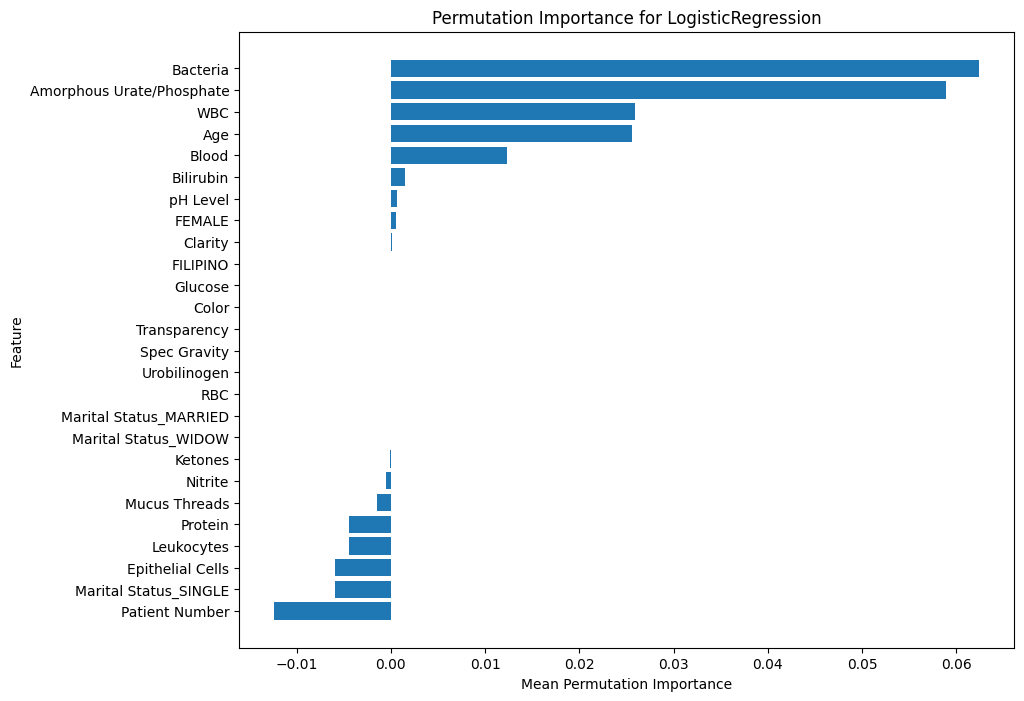

In [41]:
plot_permutation_importance(TRAINED_LOGREG, X, y, X.columns, scoring='f1')

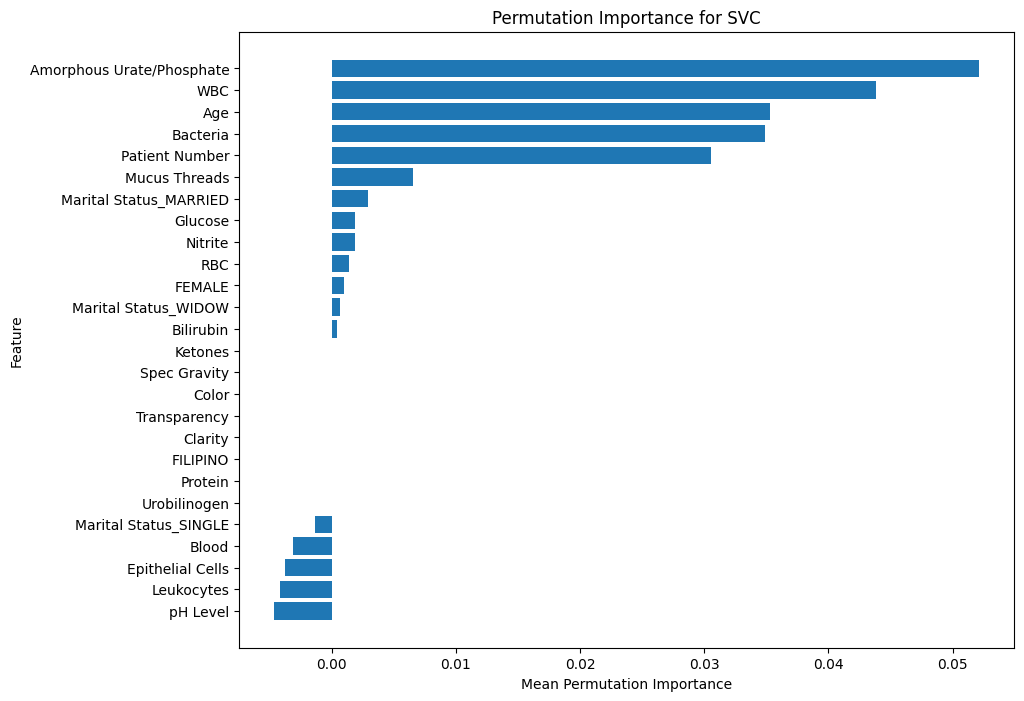

In [42]:
plot_permutation_importance(TRAINED_SVM, X, y, X.columns, scoring='f1')

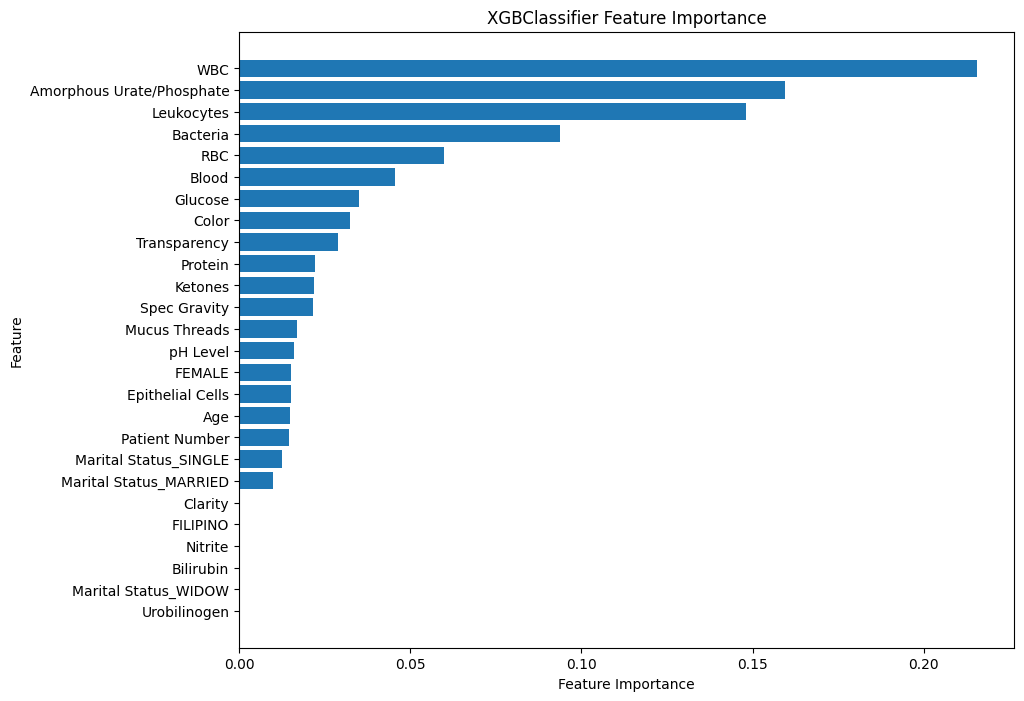

In [43]:
plot_model_feature_importance(TRAINED_XGB, X.columns)

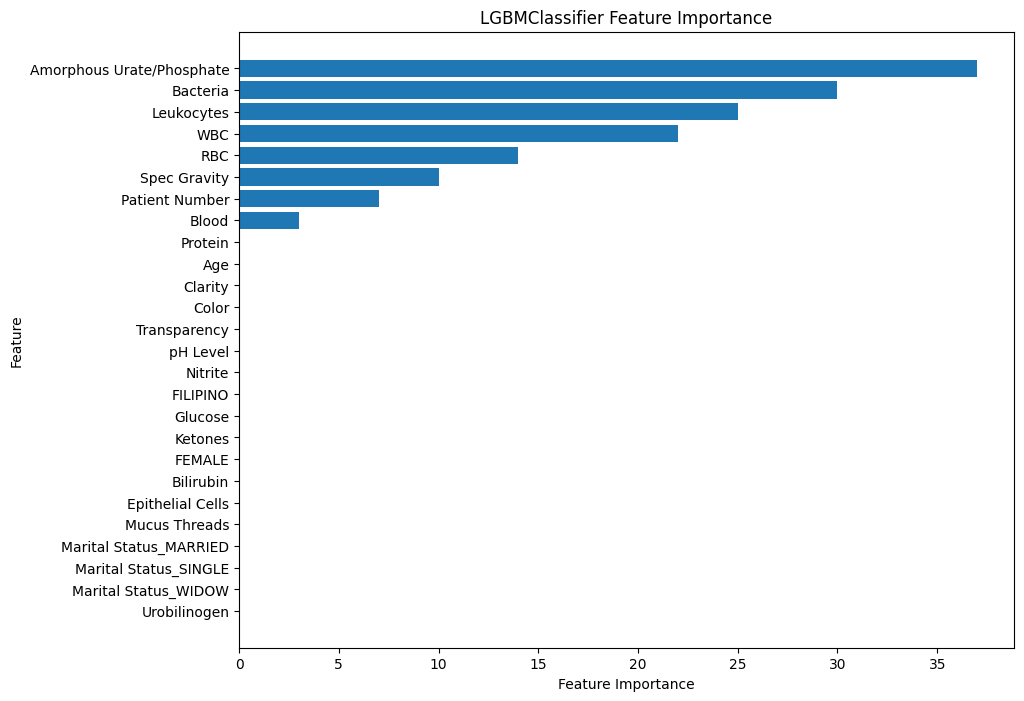

In [44]:
plot_model_feature_importance(TRAINED_LGBM, X.columns)

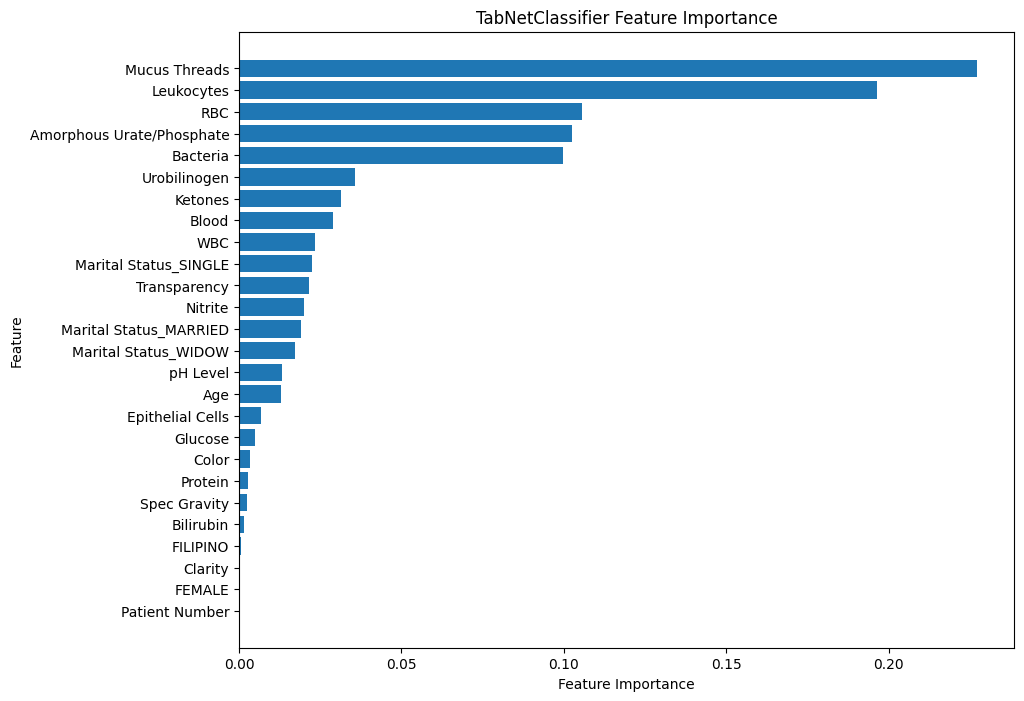

In [45]:
plot_model_feature_importance(TRAINED_TABNET, X.columns)

### TabNet SHAP

In [46]:

# explainer = shap.KernelExplainer(TRAINED_TABNET.predict, shap.sample(X_train_np, 100))
# shap_values = explainer.shap_values(X_test_np)

# # Visualize SHAP values
# shap.summary_plot(shap_values, X_test_np)

In [47]:
# # SHAP Global Positive Summary Plot
# plt.figure(figsize=(12, 8)) 
# shap.summary_plot(
#     shap_values,
#     X_test_np,
#     feature_names=X.columns,
#     show=False,
#     plot_size=(12, 8),  
# )
# plt.title("Global Positive Summary Plot (TabNet)", fontdict={"fontweight": "bold"})
# plt.gca().tick_params(axis='y', labelsize=8) 
# plt.show()

### XGB SHAP

In [48]:
XGB_EXPLAINER = shap.TreeExplainer(TRAINED_XGB, X_test)

XGB_SHAP_VALUES = XGB_EXPLAINER.shap_values(X_test, check_additivity=False)

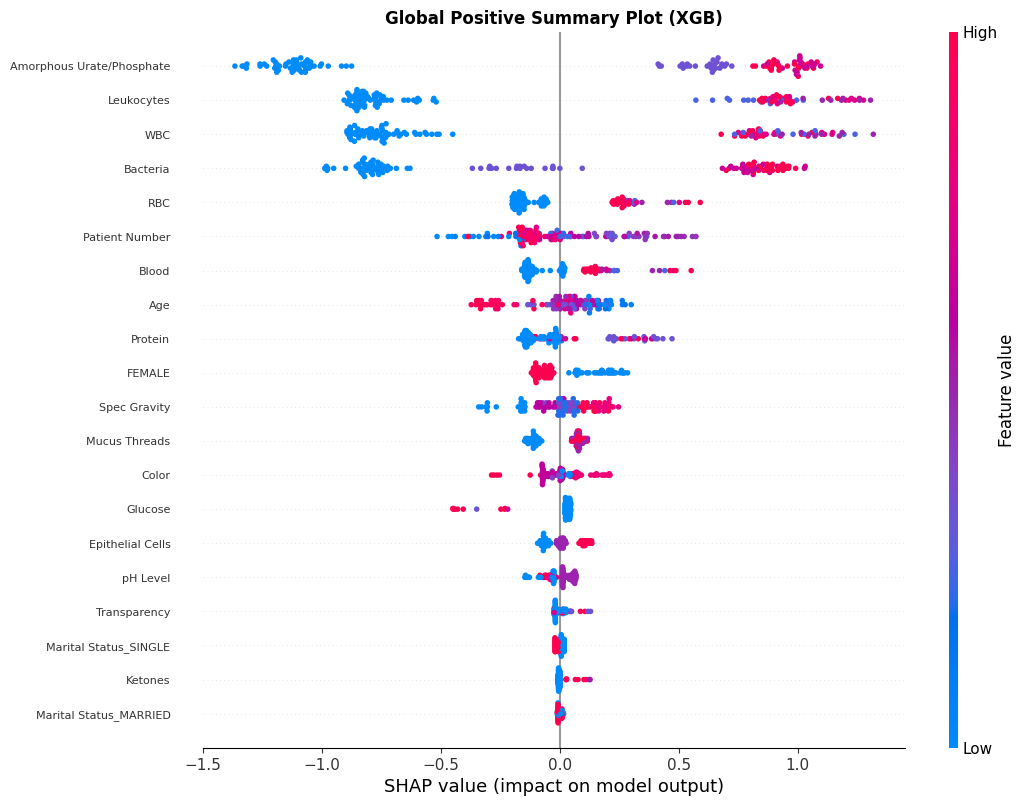

In [49]:
# SHAP Global Positive Summary Plot
plt.figure(figsize=(12, 8)) 
shap.summary_plot(
    XGB_SHAP_VALUES,
    X_test,
    feature_names=X.columns,
    show=False,
    plot_size=(12, 8),  
)
plt.title("Global Positive Summary Plot (XGB)", fontdict={"fontweight": "bold"})
plt.gca().tick_params(axis='y', labelsize=8) 
plt.show()

### LGB SHAP

In [50]:
LGBM_EXPLAINER = shap.TreeExplainer(TRAINED_LGBM, X_test)

LGBM_SHAP_VALUES = LGBM_EXPLAINER.shap_values(X_test, check_additivity=False)

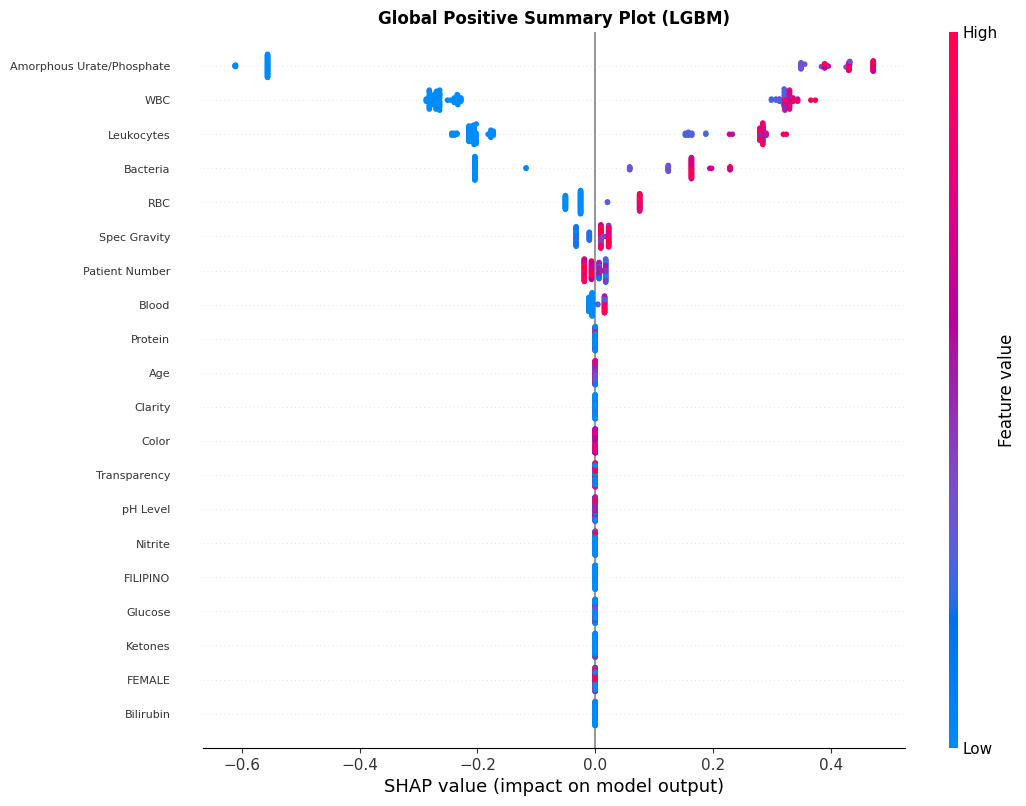

In [51]:
# SHAP Global Positive Summary Plot
plt.figure(figsize=(12, 8)) 
shap.summary_plot(
    LGBM_SHAP_VALUES,
    X_test,
    feature_names=X.columns,
    show=False,
    plot_size=(12, 8),  
)
plt.title("Global Positive Summary Plot (LGBM)", fontdict={"fontweight": "bold"})
plt.gca().tick_params(axis='y', labelsize=8) 
plt.show()

### LOGREG SHAP

In [52]:
LOGREG_EXPLAINER = shap.LinearExplainer(TRAINED_LOGREG, X_test_scaled)

LOGREG_SHAP_VALUES = LOGREG_EXPLAINER.shap_values(X_test_scaled)

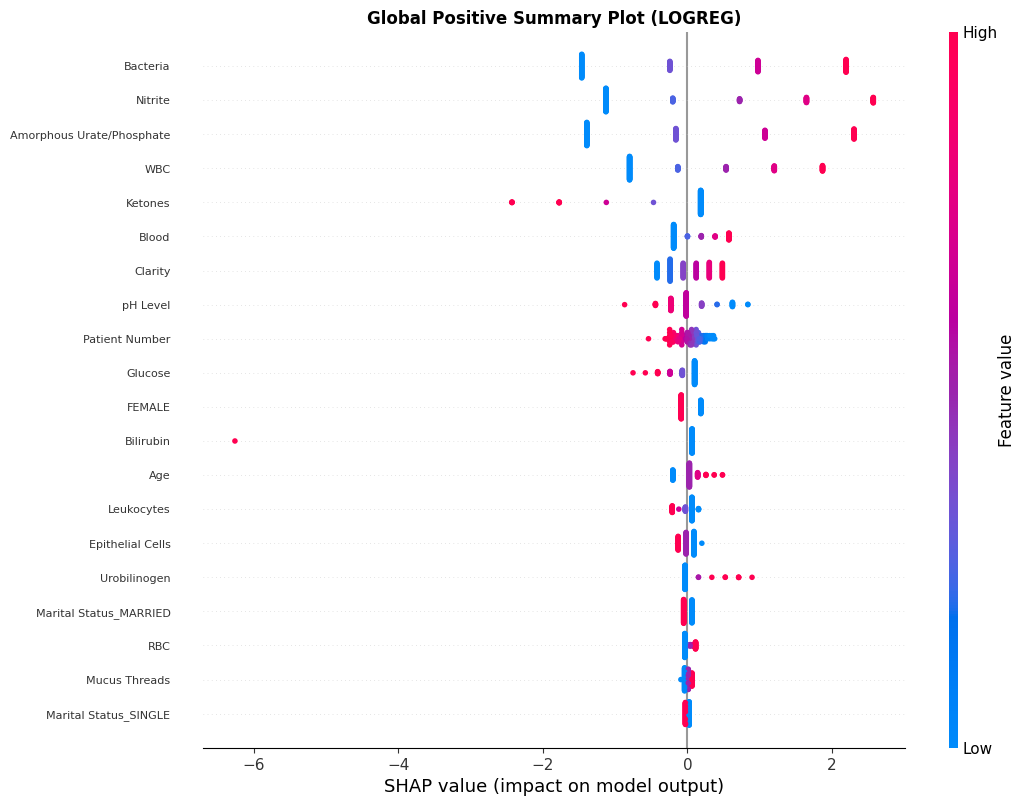

In [53]:
# SHAP Global Positive Summary Plot
plt.figure(figsize=(12, 8)) 
shap.summary_plot(
    LOGREG_SHAP_VALUES,
    X_test_scaled,
    feature_names=X.columns,
    show=False,
    plot_size=(12, 8),  
)
plt.title("Global Positive Summary Plot (LOGREG)", fontdict={"fontweight": "bold"})
plt.gca().tick_params(axis='y', labelsize=8) 
plt.show()

### SVM SHAP

In [54]:
SVM_EXPLAINER = shap.LinearExplainer(TRAINED_SVM, X_test_scaled)

SVM_SHAP_VALUES = SVM_EXPLAINER.shap_values(X_test_scaled)

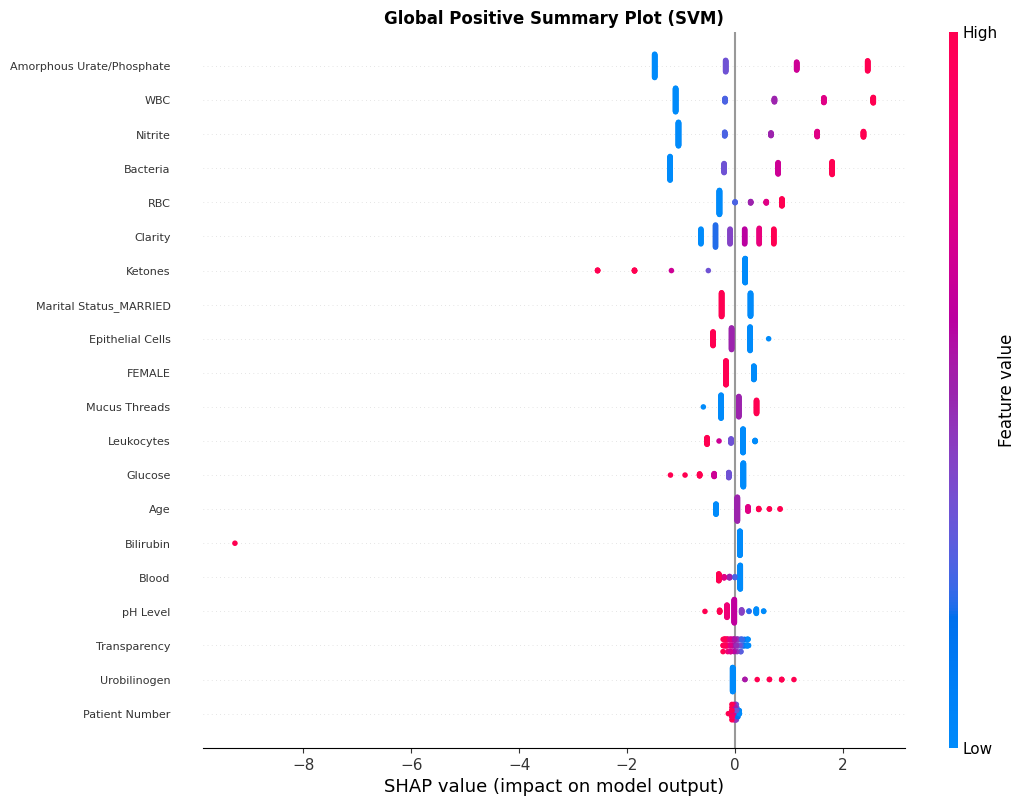

In [55]:
# SHAP Global Positive Summary Plot
plt.figure(figsize=(12, 8)) 
shap.summary_plot(
    SVM_SHAP_VALUES,
    X_test_scaled,
    feature_names=X.columns,
    show=False,
    plot_size=(12, 8),  
)
plt.title("Global Positive Summary Plot (SVM)", fontdict={"fontweight": "bold"})
plt.gca().tick_params(axis='y', labelsize=8) 
plt.show()

In [56]:
import pandas as pd

def print_top_shap_features(shap_values, feature_names, model_name="Model", top_n=10):
 
    shap_values_df = pd.DataFrame(shap_values, columns=feature_names)

    shap_values_sum = shap_values_df.abs().mean(axis=0)

    top_features = shap_values_sum.sort_values(ascending=False).head(top_n)

    print(f"\nTop {top_n} Features for {model_name} based on SHAP values:")
    print(top_features.to_frame(name='Mean Absolute SHAP Value'))

    return np.array(top_features.index)


In [57]:
top_features_svm = print_top_shap_features(SVM_SHAP_VALUES, feature_names=X.columns, model_name="SVC", top_n=10)
top_features_svm


Top 10 Features for SVC based on SHAP values:
                           Mean Absolute SHAP Value
Amorphous Urate/Phosphate                  1.336728
WBC                                        1.253002
Nitrite                                    1.180925
Bacteria                                   1.094979
RBC                                        0.409960
Clarity                                    0.402454
Ketones                                    0.345163
Marital Status_MARRIED                     0.267713
Epithelial Cells                           0.233633
FEMALE                                     0.232782


array(['Amorphous Urate/Phosphate', 'WBC', 'Nitrite', 'Bacteria', 'RBC',
       'Clarity', 'Ketones', 'Marital Status_MARRIED', 'Epithelial Cells',
       'FEMALE'], dtype=object)

In [58]:
top_features_lgbm = print_top_shap_features(LGBM_SHAP_VALUES, feature_names=X.columns, model_name="LGBMClassifier", top_n=10)
top_features_lgbm


Top 10 Features for LGBMClassifier based on SHAP values:
                           Mean Absolute SHAP Value
Amorphous Urate/Phosphate                  0.481367
WBC                                        0.290645
Leukocytes                                 0.229124
Bacteria                                   0.172950
RBC                                        0.047128
Spec Gravity                               0.019661
Patient Number                             0.013032
Blood                                      0.009862
FEMALE                                     0.000000
Marital Status_WIDOW                       0.000000


array(['Amorphous Urate/Phosphate', 'WBC', 'Leukocytes', 'Bacteria',
       'RBC', 'Spec Gravity', 'Patient Number', 'Blood', 'FEMALE',
       'Marital Status_WIDOW'], dtype=object)

In [59]:
top_features_xgb = print_top_shap_features(XGB_SHAP_VALUES, feature_names=X.columns, model_name="XGBClassifier", top_n=10)
top_features_xgb


Top 10 Features for XGBClassifier based on SHAP values:
                           Mean Absolute SHAP Value
Amorphous Urate/Phosphate                  0.956457
Leukocytes                                 0.870754
WBC                                        0.838210
Bacteria                                   0.720431
RBC                                        0.201912
Patient Number                             0.196666
Blood                                      0.135601
Age                                        0.134342
Protein                                    0.134302
FEMALE                                     0.108344


array(['Amorphous Urate/Phosphate', 'Leukocytes', 'WBC', 'Bacteria',
       'RBC', 'Patient Number', 'Blood', 'Age', 'Protein', 'FEMALE'],
      dtype=object)

In [60]:
top_features_logreg = print_top_shap_features(LOGREG_SHAP_VALUES, feature_names=X.columns, model_name="LogisitcRegression", top_n=10)


Top 10 Features for LogisitcRegression based on SHAP values:
                           Mean Absolute SHAP Value
Bacteria                                   1.332190
Nitrite                                    1.273046
Amorphous Urate/Phosphate                  1.250832
WBC                                        0.912190
Ketones                                    0.329111
Blood                                      0.269545
Clarity                                    0.269206
pH Level                                   0.190519
Patient Number                             0.153022
Glucose                                    0.136706


# REDUCED MODELS


In [61]:
all_features = X.columns.tolist()  

print(all_features)  


['Patient Number', 'Age', 'Clarity', 'Color', 'Transparency', 'Spec Gravity', 'pH Level', 'Leukocytes', 'Nitrite', 'Protein', 'Glucose', 'Ketones', 'Urobilinogen', 'Bilirubin', 'Blood', 'Bacteria', 'Epithelial Cells', 'RBC', 'WBC', 'Mucus Threads', 'Amorphous Urate/Phosphate', 'Marital Status_MARRIED', 'Marital Status_SINGLE', 'Marital Status_WIDOW', 'FEMALE', 'FILIPINO']


In [62]:
# Convert the top feature names to their corresponding indices in the original feature list
top_feature_indices_logreg = [all_features.index(feature) for feature in top_features_logreg]
top_feature_indices_lgbm = [all_features.index(feature) for feature in top_features_lgbm]
top_feature_indices_xgb = [all_features.index(feature) for feature in top_features_xgb]
top_feature_indices_svm = [all_features.index(feature) for feature in top_features_svm]

# Select only the top 10 features for each model
X_train_logreg = X_train_scaled[:, top_feature_indices_logreg]
X_val_logreg = X_val_scaled[:, top_feature_indices_logreg]
X_test_logreg = X_test_scaled[:, top_feature_indices_logreg]

X_train_lgbm = X_train.iloc[:, top_feature_indices_lgbm]
X_val_lgbm = X_val.iloc[:, top_feature_indices_lgbm]
X_test_lgbm = X_test.iloc[:, top_feature_indices_lgbm]

X_train_xgb = X_train.iloc[:, top_feature_indices_xgb]
X_val_xgb = X_val.iloc[:, top_feature_indices_xgb]
X_test_xgb = X_test.iloc[:, top_feature_indices_xgb]

X_train_svm = X_train_scaled[:, top_feature_indices_svm]
X_val_svm = X_val_scaled[:, top_feature_indices_svm]
X_test_svm = X_test_scaled[:, top_feature_indices_svm]



### Reduced Logistic Regression

In [63]:
def logreg_objective_r(trial: optuna.study.Study) -> float:
    PARAMS = {
        "tol": trial.suggest_float("tol", 1e-6, 1e-2, log=True),
        "C": trial.suggest_float("C", 0.1, 1)
    }

    LOGREG_R = LogisticRegression(**PARAMS, max_iter=2000, random_state=42)

    LOGREG_R.fit(X_train_logreg, y_train)

    THRESHOLD = trial.suggest_float('threshold', 0.1, 1)

    YHAT = [1 if proba[1] > THRESHOLD else 0 for proba in LOGREG_R.predict_proba(X_val_logreg)]

    F1_SCORE_ = f1_score(y_val, YHAT)

    return F1_SCORE_

SEED = 42  
SAMPLER = optuna.samplers.TPESampler(seed=SEED)

LOGREG_STUDY_R = optuna.create_study(direction="maximize", study_name="logreg_tuning_r", sampler=SAMPLER)

LOGREG_STUDY_R.optimize(logreg_objective_r, n_trials=200, n_jobs=-1, show_progress_bar=True)

[I 2024-12-26 21:49:30,770] A new study created in memory with name: logreg_tuning_r


  0%|          | 0/200 [00:00<?, ?it/s]

[I 2024-12-26 21:49:30,850] Trial 0 finished with value: 0.9473684210526315 and parameters: {'tol': 1.8599622032902426e-05, 'C': 0.9968366771992672, 'threshold': 0.6276259589657529}. Best is trial 0 with value: 0.9473684210526315.
[I 2024-12-26 21:49:30,927] Trial 4 finished with value: 0.9666666666666667 and parameters: {'tol': 0.007929297355590559, 'C': 0.2550464831071186, 'threshold': 0.26677498993018356}. Best is trial 4 with value: 0.9666666666666667.
[I 2024-12-26 21:49:30,937] Trial 2 finished with value: 0.9655172413793104 and parameters: {'tol': 0.0005081776092468336, 'C': 0.6476715149789887, 'threshold': 0.494273180993691}. Best is trial 4 with value: 0.9666666666666667.
[I 2024-12-26 21:49:30,993] Trial 1 finished with value: 0.9473684210526315 and parameters: {'tol': 4.729893123892354e-05, 'C': 0.9495910784578451, 'threshold': 0.6241305104053735}. Best is trial 4 with value: 0.9666666666666667.
[I 2024-12-26 21:49:30,997] Trial 5 finished with value: 0.9655172413793104 and 

In [64]:
show_study_summary(LOGREG_STUDY_R)

Best Hyperparameters
{'C': 0.9115494606982716,
 'threshold': 0.2936623718745373,
 'tol': 0.00026673198469183114}

Accuracy for the Best Hyperparameters
0.9830508474576272


### Reduced SVM

In [65]:
def SVC_objective_r(trial: optuna.study.Study) -> float:
    PARAMS = {
        "C": trial.suggest_float("C", 0.1, 1, log=True),
        "kernel": trial.suggest_categorical("kernel", ["linear", "poly", "rbf", "sigmoid"])
    }

    SVC_MODEL_R = SVC(**PARAMS, probability=True, random_state=42)

    SVC_MODEL_R.fit(X_train_svm, y_train)

    YHAT = SVC_MODEL_R.predict(X_val_svm)

    F1_SCORE_ = f1_score(y_val, YHAT)

    return F1_SCORE_

SEED = 42  
SAMPLER = optuna.samplers.TPESampler(seed=SEED)

SVM_SVC_STUDY_R = optuna.create_study(direction="maximize", study_name="SVM_tuning_r", sampler=SAMPLER)

SVM_SVC_STUDY_R.optimize(SVC_objective_r, n_trials=200, n_jobs=-1, show_progress_bar=True)

[I 2024-12-26 21:49:36,473] A new study created in memory with name: SVM_tuning_r


  0%|          | 0/200 [00:00<?, ?it/s]

[I 2024-12-26 21:49:36,521] Trial 0 finished with value: 0.9473684210526315 and parameters: {'C': 0.2811623671555496, 'kernel': 'linear'}. Best is trial 0 with value: 0.9473684210526315.
[I 2024-12-26 21:49:36,542] Trial 2 finished with value: 0.9491525423728814 and parameters: {'C': 0.65818797614992, 'kernel': 'linear'}. Best is trial 2 with value: 0.9491525423728814.
[I 2024-12-26 21:49:36,565] Trial 5 finished with value: 0.9491525423728814 and parameters: {'C': 0.4543769597759802, 'kernel': 'linear'}. Best is trial 2 with value: 0.9491525423728814.
[I 2024-12-26 21:49:36,572] Trial 1 finished with value: 0.9090909090909091 and parameters: {'C': 0.3821836619788531, 'kernel': 'poly'}. Best is trial 2 with value: 0.9491525423728814.
[I 2024-12-26 21:49:36,574] Trial 3 finished with value: 0.9523809523809523 and parameters: {'C': 0.10998853859887023, 'kernel': 'sigmoid'}. Best is trial 3 with value: 0.9523809523809523.
[I 2024-12-26 21:49:36,586] Trial 4 finished with value: 0.96666666

In [66]:
show_study_summary(SVM_SVC_STUDY_R)

Best Hyperparameters
{'C': 0.5680716556278625, 'kernel': 'rbf'}

Accuracy for the Best Hyperparameters
0.9830508474576272


### Reduced XGB

In [67]:
def XGB_objective_r(trial: optuna.study.Study) -> float:

    PARAMS = {
        "objective": "binary:logistic",
        "booster": "gbtree",
        "reg_alpha": trial.suggest_float("reg_alpha", 0.1, 0.9),
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000, step=50),
        "max_depth": trial.suggest_int("max_depth", 3, 15),
        "learning_rate": trial.suggest_float("learning_rate", 0.0001, 0.1, log=True),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0)
        
    }

    XGB_MODEL_R = xgb.XGBClassifier(**PARAMS, random_state=42)

    XGB_MODEL_R.fit(X_train_xgb, y_train)

    YHAT = XGB_MODEL_R.predict(X_val_xgb)

    F1_SCORE_ = f1_score(y_val, YHAT)

    return F1_SCORE_

SEED = 42  
SAMPLER = optuna.samplers.TPESampler(seed=SEED)

XGB_STUDY_R = optuna.create_study(direction="maximize", study_name="XGB_tuning_r", sampler=SAMPLER)

XGB_STUDY_R.optimize(XGB_objective_r, n_trials=200, n_jobs=-1, show_progress_bar=True)

[I 2024-12-26 21:49:39,988] A new study created in memory with name: XGB_tuning_r


  0%|          | 0/200 [00:00<?, ?it/s]

[I 2024-12-26 21:49:40,646] Trial 7 finished with value: 0.9090909090909091 and parameters: {'reg_alpha': 0.42376769569238737, 'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.00010715632779660475, 'subsample': 0.7802243131770358, 'colsample_bytree': 0.7632628686011922}. Best is trial 7 with value: 0.9090909090909091.
[I 2024-12-26 21:49:40,786] Trial 4 finished with value: 0.9830508474576272 and parameters: {'reg_alpha': 0.7702922043102034, 'n_estimators': 400, 'max_depth': 6, 'learning_rate': 0.005900047652625297, 'subsample': 0.7558720254094375, 'colsample_bytree': 0.828955205168691}. Best is trial 4 with value: 0.9830508474576272.
[I 2024-12-26 21:49:40,817] Trial 6 finished with value: 0.9830508474576272 and parameters: {'reg_alpha': 0.6617296982568904, 'n_estimators': 450, 'max_depth': 15, 'learning_rate': 0.026071693583447936, 'subsample': 0.6591390105278703, 'colsample_bytree': 0.5191589374010114}. Best is trial 4 with value: 0.9830508474576272.
[I 2024-12-26 21:49:40,89

In [68]:
show_study_summary(XGB_STUDY_R)

Best Hyperparameters
{'colsample_bytree': 0.828955205168691,
 'learning_rate': 0.005900047652625297,
 'max_depth': 6,
 'n_estimators': 400,
 'reg_alpha': 0.7702922043102034,
 'subsample': 0.7558720254094375}

Accuracy for the Best Hyperparameters
0.9830508474576272


### Reduced LGBM

In [69]:
def lightgbm_objective_r(trial: optuna.study.Study) -> float:

    PARAMS = {
        "data_sample_strategy": "goss",
        "verbosity": -1,
        "boosting_type": trial.suggest_categorical("boosting_type", ["gbdt", "dart"]),
        "num_leaves": trial.suggest_int('num_leaves', 10, 200, step=10),
        "n_estimators": trial.suggest_int("n_estimators", 100, 500, step=50),
        "max_depth": trial.suggest_categorical("max_depth", [-1, 3, 4, 5]),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        "learning_rate": trial.suggest_float("learning_rate", 0.0001, 0.1, log=True),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.1, 0.9),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0)
    }
    
    LGMB_MODEL_R = lgb.LGBMClassifier(**PARAMS, random_state=42)
    
    LGMB_MODEL_R.fit(X_train_lgbm, y_train) 
    
    YHAT = LGMB_MODEL_R.predict(X_val_lgbm)
    
    F1_SCORE_ = f1_score(y_val, YHAT)
    
    return F1_SCORE_

SEED = 42  
SAMPLER = optuna.samplers.TPESampler(seed=SEED)

LGBM_STUDY_R = optuna.create_study(direction="maximize", study_name="lgbm_tuning_r", sampler=SAMPLER)

LGBM_STUDY_R.optimize(lightgbm_objective_r, n_trials=200, n_jobs=-1, show_progress_bar=True)

[I 2024-12-26 21:50:28,979] A new study created in memory with name: lgbm_tuning_r


  0%|          | 0/200 [00:00<?, ?it/s]

[I 2024-12-26 21:50:29,109] Trial 7 finished with value: 0.9830508474576272 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 190, 'n_estimators': 250, 'max_depth': 4, 'min_child_samples': 87, 'learning_rate': 0.02998086204527518, 'reg_alpha': 0.18982694235166175, 'subsample': 0.6355216745649861, 'colsample_bytree': 0.7580251582862175}. Best is trial 7 with value: 0.9830508474576272.
[I 2024-12-26 21:50:29,141] Trial 0 finished with value: 0.6 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 60, 'n_estimators': 300, 'max_depth': 3, 'min_child_samples': 98, 'learning_rate': 0.0017549131877680616, 'reg_alpha': 0.541302680226613, 'subsample': 0.872278296288026, 'colsample_bytree': 0.8327436484902506}. Best is trial 7 with value: 0.9830508474576272.
[I 2024-12-26 21:50:29,180] Trial 1 finished with value: 0.9830508474576272 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 190, 'n_estimators': 250, 'max_depth': 5, 'min_child_samples': 33, 'learning_rate': 0.0054964173131

In [70]:
show_study_summary(LGBM_STUDY_R)

Best Hyperparameters
{'boosting_type': 'gbdt',
 'colsample_bytree': 0.5004303425798293,
 'learning_rate': 0.0012203656364112789,
 'max_depth': 5,
 'min_child_samples': 35,
 'n_estimators': 450,
 'num_leaves': 70,
 'reg_alpha': 0.3737458192261457,
 'subsample': 0.9429764324497284}

Accuracy for the Best Hyperparameters
1.0


In [71]:
LIST_OF_MODELS_R = [LogisticRegression, SVC, xgb.XGBClassifier, lgb.LGBMClassifier]

MODELS_PARAMETERS_R = {
    "LogisticRegression_R": {'C': 0.10308280800203848,
                             'threshold': 0.2944200476324134,
                             'tol': 1.3931950752414964e-06},
    "SVC_R": {'C': 0.2477851173337074, 'kernel': 'linear', 'probability': True},
    "XGBClassifier_R": {'colsample_bytree': 0.7269862263631472,
                        'learning_rate': 0.0025485947655715917,
                        'max_depth': 11,
                        'n_estimators': 200,
                        'reg_alpha': 0.2591212414395312,
                        'subsample': 0.5953510541214844},
    "LGBMClassifier_R": {"data_sample_strategy": "goss", "verbosity": -1,
                         'boosting_type': 'gbdt',
                         'colsample_bytree': 0.7675622325300444,
                         'learning_rate': 0.09608006205949848,
                         'max_depth': -1,
                         'min_child_camples': 250,
                         'n_estimators': 350,
                         'num_leaves': 110,
                         'reg_alpha': 0.2710651885834765,
                         'subsample': 0.7894543424446958}
}

X_train_list = [
    X_train_logreg,  # LogisticRegression
    X_train_svm,     # SVC
    X_train_xgb,     # XGBClassifier
    X_train_lgbm     # LGBMClassifier
]

X_test_list = [
    X_test_logreg,  # LogisticRegression
    X_test_svm,     # SVC
    X_test_xgb,     # XGBClassifier
    X_test_lgbm     # LGBMClassifier
]

MODEL_CONTAINER_R = {}

TESTING_SCORES_R = pd.DataFrame(columns=["Model", "Accuracy", "Precision", "Recall", "F1-Score", "Specificity", "AUC-ROC"])

for i, model_class in enumerate(LIST_OF_MODELS_R):
    # Get current train and test data
    X_train_current = X_train_list[i]
    X_test_current = X_test_list[i]

    # Determine model name and parameters
    model_name = list(MODELS_PARAMETERS_R.keys())[i]
    model_params = MODELS_PARAMETERS_R[model_name]

    # Use the test_model function to train and evaluate the model
    model_container, test_scores = test_model(
        models=[model_class],
        params={model_name: model_params},
        X_train=X_train_current,
        y_train=y_train,
        X_test=X_test_current,
        y_test=y_test,
        X_train_scaled=X_train_current,  
        X_test_scaled=X_test_current     
    )

    # Store the trained model in the container
    MODEL_CONTAINER_R[model_name] = model_container[model_name]

    TESTING_SCORES_R = pd.concat([TESTING_SCORES_R, test_scores], ignore_index=True)

print(TESTING_SCORES_R)


100%|██████████| 1/1 [00:00<00:00, 20.83it/s]

                  Model  Accuracy  Precision    Recall  F1-Score  Specificity  \
0  LogisticRegression_R  0.943548   0.911765  0.984127  0.946565     0.901639   
1                 SVC_R  0.927419   0.935484  0.920635  0.928000     0.934426   
2       XGBClassifier_R  0.967742   0.968254  0.968254  0.968254     0.967213   
3      LGBMClassifier_R  0.959677   0.967742  0.952381  0.960000     0.967213   

    AUC-ROC  
0  0.942883  
1  0.927531  
2  0.967734  
3  0.959797  


In [72]:
TESTING_SCORES_R

Model  Accuracy  Precision    Recall  F1-Score  Specificity  \
0  LogisticRegression_R  0.943548   0.911765  0.984127  0.946565     0.901639   
1                 SVC_R  0.927419   0.935484  0.920635  0.928000     0.934426   
2       XGBClassifier_R  0.967742   0.968254  0.968254  0.968254     0.967213   
3      LGBMClassifier_R  0.959677   0.967742  0.952381  0.960000     0.967213   

    AUC-ROC  
0  0.942883  
1  0.927531  
2  0.967734  
3  0.959797

### Reduced Models Evaluation

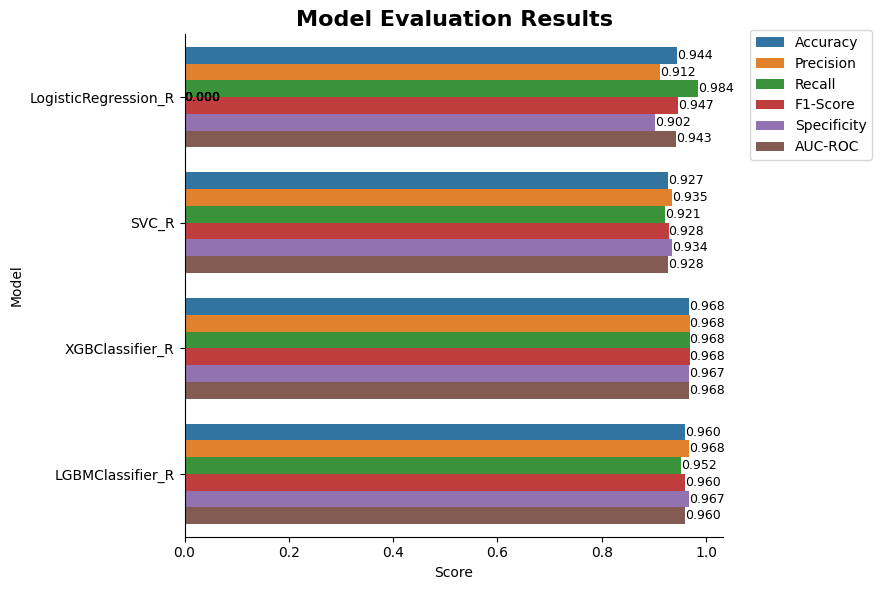

In [73]:
plot_df = pd.melt(TESTING_SCORES_R, id_vars=["Model"])
plot_df.rename({"variable": "Metric", "value": "Score"}, axis=1, inplace=True)

PLOT = sns.catplot(
    x="Score", 
    y="Model", 
    hue="Metric", 
    data=plot_df, 
    kind="bar", 
    orient="h",
    height=6, 
    aspect=1.5, 
    legend_out=False,
    palette="tab10"  
)

ax = PLOT.axes[0, 0]

for p in ax.patches:
    ax.annotate(f"{p.get_width():.3f}", 
                (p.get_x() + p.get_width(), p.get_y() + p.get_height() / 2),
                ha="left", va="center", fontsize=9)

plt.title("Model Evaluation Results", fontsize=16, fontweight='bold')
plt.legend(loc=(1.05, 0.75))
plt.tight_layout()

plt.show()

In [74]:
TRAINED_XGB_R = MODEL_CONTAINER_R["XGBClassifier_R"]
TRAINED_LGBM_R = MODEL_CONTAINER_R["LGBMClassifier_R"]
TRAINED_SVM_R = MODEL_CONTAINER_R["SVC_R"]
TRAINED_LOGREG_R = MODEL_CONTAINER_R["LogisticRegression_R"]

In [75]:
MODELS_TESTING_SCORES = pd.concat([TESTING_SCORES, TESTING_SCORES_R], axis=0)
MODELS_TESTING_SCORES

Model  Accuracy  Precision    Recall  F1-Score  Specificity  \
0    LogisticRegression  0.943548   0.911765  0.984127  0.946565     0.901639   
1                   SVC  0.935484   0.936508  0.936508  0.936508     0.934426   
2         XGBClassifier  0.967742   0.953846  0.984127  0.968750     0.950820   
3        LGBMClassifier  0.927419   0.935484  0.920635  0.928000     0.934426   
4      TabNetClassifier  0.911290   0.893939  0.936508  0.914729     0.885246   
0  LogisticRegression_R  0.943548   0.911765  0.984127  0.946565     0.901639   
1                 SVC_R  0.927419   0.935484  0.920635  0.928000     0.934426   
2       XGBClassifier_R  0.967742   0.968254  0.968254  0.968254     0.967213   
3      LGBMClassifier_R  0.959677   0.967742  0.952381  0.960000     0.967213   

    AUC-ROC  
0  0.942883  
1  0.935467  
2  0.967473  
3  0.927531  
4  0.910877  
0  0.942883  
1  0.927531  
2  0.967734  
3  0.959797

### Comparison of Full and Reduced Models (H2H)

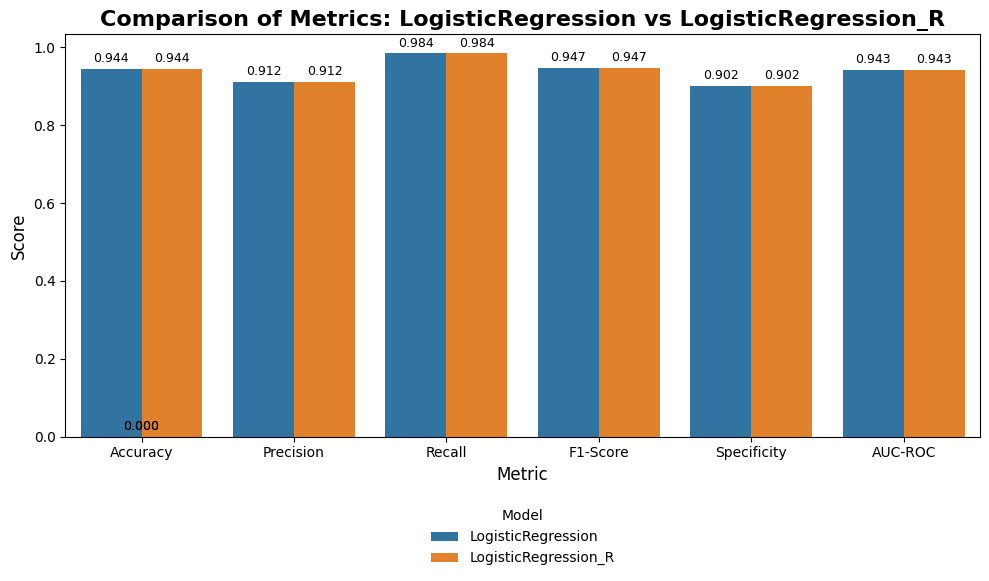

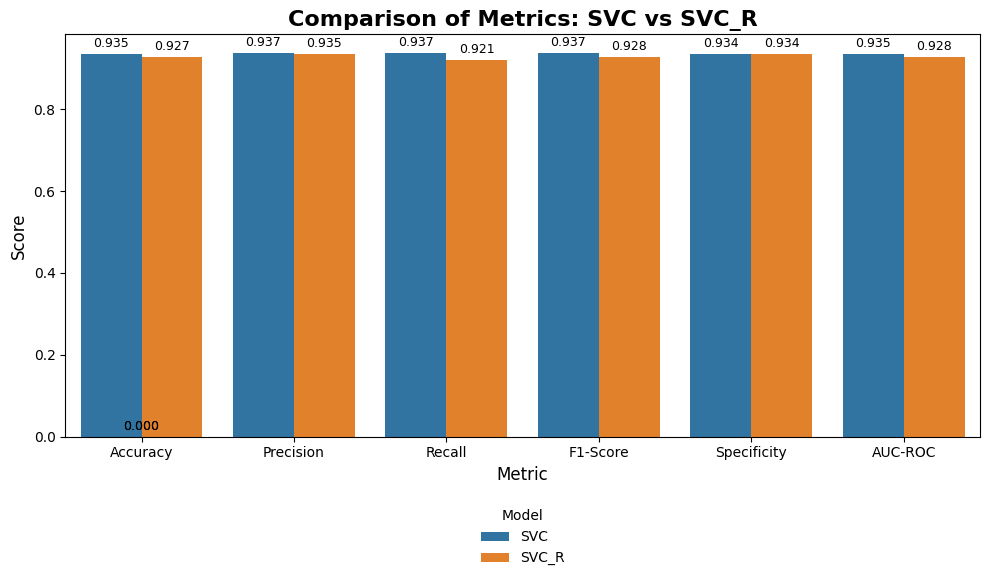

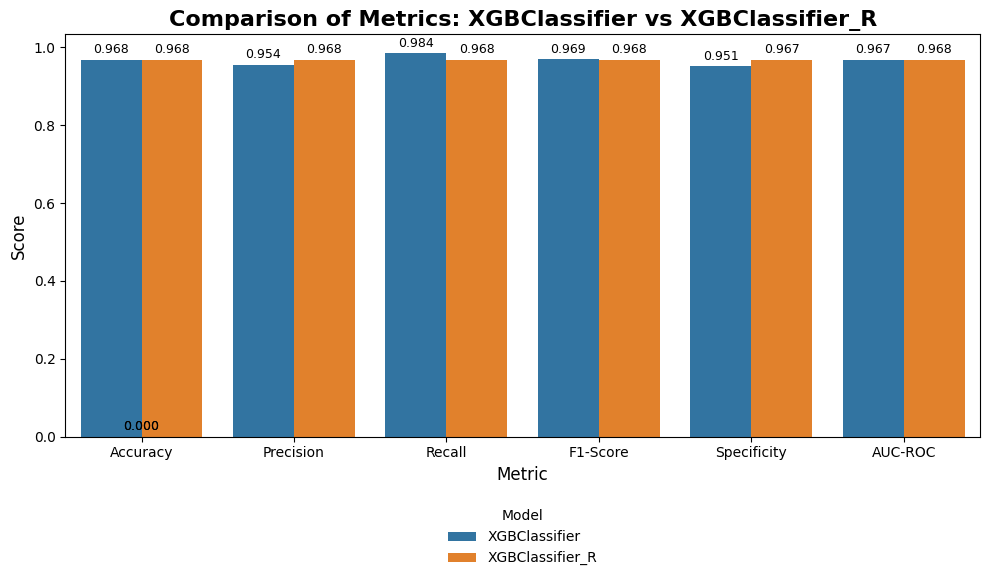

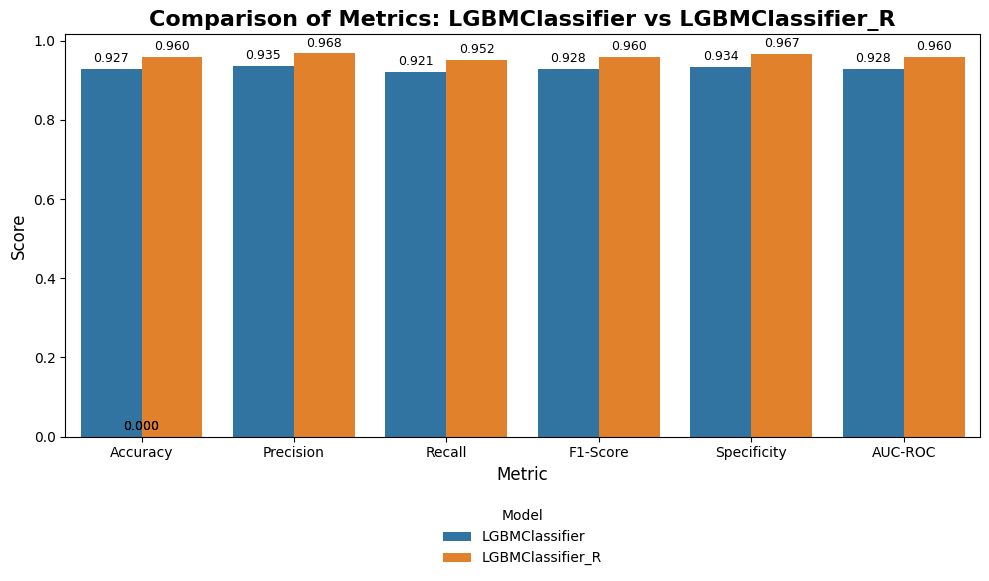

In [76]:
normal_models = TESTING_SCORES['Model'].unique()
reduced_models = TESTING_SCORES_R['Model'].unique()

# Loop through each model and its reduced counterpart
for normal_model, reduced_model in zip(normal_models, reduced_models):
    
    normal_model_scores = TESTING_SCORES[TESTING_SCORES['Model'] == normal_model]
    reduced_model_scores = TESTING_SCORES_R[TESTING_SCORES_R['Model'] == reduced_model]
    
    combined_scores = pd.concat([normal_model_scores, reduced_model_scores])

    plot_df = pd.melt(combined_scores, id_vars=["Model"], var_name="Metric", value_name="Score")
    
    # Create a bar plot
    plt.figure(figsize=(10, 6))
    sns.barplot(
        x="Metric", 
        y="Score", 
        hue="Model", 
        data=plot_df, 
        palette=["#1f77b4", "#ff7f0e"] 
    )
    
    ax = plt.gca()
    for p in ax.patches:
        ax.annotate(
            f"{p.get_height():.3f}",
            (p.get_x() + p.get_width() / 2., p.get_height() + 0.01),
            ha="center", va="bottom", fontsize=9
        )
    
    plt.title(f"Comparison of Metrics: {normal_model} vs {reduced_model}", fontsize=16, fontweight='bold')
    plt.xlabel("Metric", fontsize=12)
    plt.ylabel("Score", fontsize=12)
    
    plt.legend(
        title="Model", 
        loc="upper center", 
        bbox_to_anchor=(0.5, -0.15),  
        fontsize=10,  
        title_fontsize=10,  
        frameon=False  
    )
    
    plt.tight_layout()
    plt.show()


## ENSEMBLE MODELING

In [77]:
XGB_PREDICTED_PROBA = TRAINED_XGB.predict_proba(X_test)
XGB_R_PREDICTED_PROBA = TRAINED_XGB_R.predict_proba(X_test_xgb)
LOGREG_R_PREDICTED_PROBA = TRAINED_LOGREG_R.predict_proba(X_test_logreg)
LGBM_R_PREDICTED_PROBA = TRAINED_LGBM_R.predict_proba(X_test_lgbm)
SVM_R_PREDICTED_PROBA = TRAINED_SVM_R.predict_proba(X_test_svm)

LOGREG_R_SCALED_PROBA = LOGREG_R_PREDICTED_PROBA.copy()
scaling_factor = np.where(
    LOGREG_R_SCALED_PROBA[:, 1] >= 0.29,
    1,  
    LOGREG_R_SCALED_PROBA[:, 1] / 0.29  
)
LOGREG_R_SCALED_PROBA[:, 1] *= scaling_factor
LOGREG_R_SCALED_PROBA[:, 0] = 1 - LOGREG_R_SCALED_PROBA[:, 1]  

In [78]:
weight_xgb = 0.3
weight_xgb_r = 0.3
weight_logreg_r = 0.3
weight_lgbm_r = 0.3
weight_svm_r = 0.3 


TOP3_WAVERAGE_PREDICTIONS = (weight_xgb_r * XGB_R_PREDICTED_PROBA + weight_xgb * XGB_PREDICTED_PROBA + weight_logreg_r * LOGREG_R_SCALED_PROBA) / (weight_xgb_r + weight_xgb + weight_logreg_r)

TOP3_WAVERAGE_PREDICTIONS_R = (weight_xgb_r * XGB_R_PREDICTED_PROBA + weight_lgbm_r * LGBM_R_PREDICTED_PROBA + weight_logreg_r * LOGREG_R_SCALED_PROBA) / (weight_xgb_r + weight_lgbm_r + weight_logreg_r)

In [79]:
TOP3_LABELED_PREDICTIONS = np.argmax(TOP3_WAVERAGE_PREDICTIONS, axis=1)

TOP3_LABELED_PREDICTIONS_R = np.argmax(TOP3_WAVERAGE_PREDICTIONS_R, axis=1)

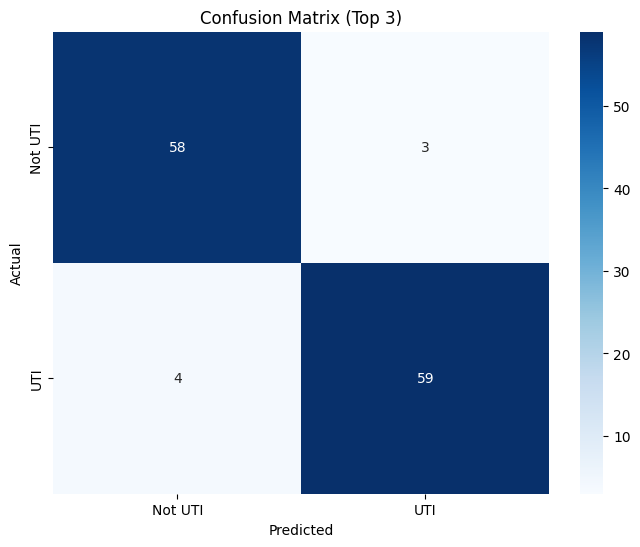

In [80]:
T3_CM = confusion_matrix(y_test, TOP3_LABELED_PREDICTIONS)

plt.figure(figsize=(8, 6))
sns.heatmap(T3_CM, annot=True, fmt="d", cmap="Blues", cbar=True,
            xticklabels=["Not UTI", "UTI"], yticklabels=["Not UTI", "UTI"])
plt.title("Confusion Matrix (Top 3)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

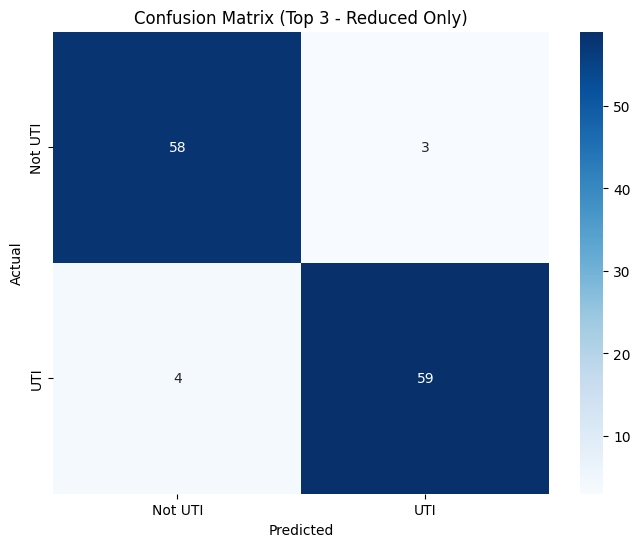

In [81]:
T3_CM_R = confusion_matrix(y_test, TOP3_LABELED_PREDICTIONS_R)

plt.figure(figsize=(8, 6))
sns.heatmap(T3_CM_R, annot=True, fmt="d", cmap="Blues", cbar=True,
            xticklabels=["Not UTI", "UTI"], yticklabels=["Not UTI", "UTI"])
plt.title("Confusion Matrix (Top 3 - Reduced Only)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [82]:
# Compute evaluation metrics using scikit-learn functions
T3_ACCURACY = accuracy_score(y_test, TOP3_LABELED_PREDICTIONS)
T3_F1 = f1_score(y_test, TOP3_LABELED_PREDICTIONS)
T3_RECALL = recall_score(y_test, TOP3_LABELED_PREDICTIONS)
T3_PRECISION = precision_score(y_test, TOP3_LABELED_PREDICTIONS)

T3R_ACCURACY = accuracy_score(y_test, TOP3_LABELED_PREDICTIONS_R)
T3R_F1 = f1_score(y_test, TOP3_LABELED_PREDICTIONS_R)
T3R_RECALL = recall_score(y_test, TOP3_LABELED_PREDICTIONS_R)
T3R_PRECISION = precision_score(y_test, TOP3_LABELED_PREDICTIONS_R)

# Compute additional metrics (confusion matrix, specificity, ROC AUC)
T3_TN, T3_FP, _, _ = confusion_matrix(y_test, TOP3_LABELED_PREDICTIONS).ravel()
T3_SPECIFICITY = T3_TN / (T3_TN + T3_FP)
T3_ROC_AUC = roc_auc_score(y_test, TOP3_LABELED_PREDICTIONS)

T3R_TN, T3R_FP, _, _ = confusion_matrix(y_test, TOP3_LABELED_PREDICTIONS_R).ravel()
T3R_SPECIFICITY = T3R_TN / (T3R_TN + T3R_FP)
T3R_ROC_AUC = roc_auc_score(y_test, TOP3_LABELED_PREDICTIONS_R)

### Ensemble Model Metrics

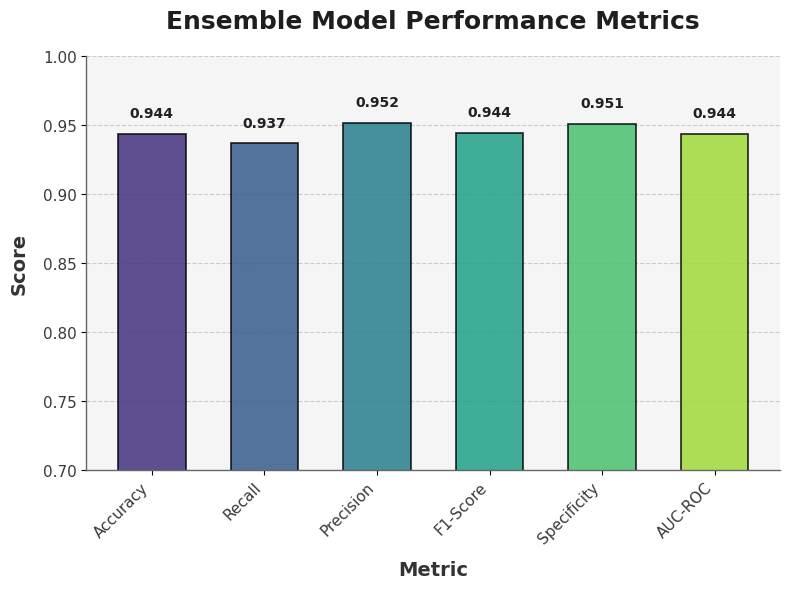

In [83]:
metrics = ["Accuracy", "Recall", "Precision", "F1-Score", "Specificity", "AUC-ROC"]
scores = [T3_ACCURACY, T3_RECALL, T3_PRECISION, T3_F1, T3_SPECIFICITY, T3_ROC_AUC]
colors = sns.color_palette("viridis", len(metrics))  # Use Viridis for a modern gradient

plt.figure(figsize=(8, 6))  

bars = plt.bar(
    metrics, 
    scores, 
    color=colors, 
    edgecolor="black", 
    linewidth=1.2, 
    alpha=0.85,  
    width=0.6
)

for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2, 
        height + 0.01, 
        f"{height:.3f}", 
        ha="center", 
        va="bottom", 
        fontsize=10, 
        fontweight="bold", 
        color="#212121"
    )

plt.title("Ensemble Model Performance Metrics", fontsize=18, weight='bold', color="#1E1E1E", pad=20)
plt.xlabel("Metric", fontsize=14, labelpad=10, weight='bold', color="#333333")
plt.ylabel("Score", fontsize=14, labelpad=10, weight='bold', color="#333333")

plt.xticks(fontsize=11, color="#3A3A3A", fontweight="medium", rotation=45, ha="right")
plt.yticks(fontsize=11, color="#3A3A3A", fontweight="medium")

plt.grid(axis="y", linestyle="--", alpha=0.5, color="#A0A0A0")

plt.gca().patch.set_facecolor("#F5F5F5")
plt.gca().patch.set_alpha(1)
plt.gca().set_axisbelow(True)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_linewidth(1.0)
plt.gca().spines['bottom'].set_linewidth(1.0)
plt.gca().spines['left'].set_color("#666666")
plt.gca().spines['bottom'].set_color("#666666")


plt.ylim(0.7, 1.0)
plt.tight_layout()
plt.show()


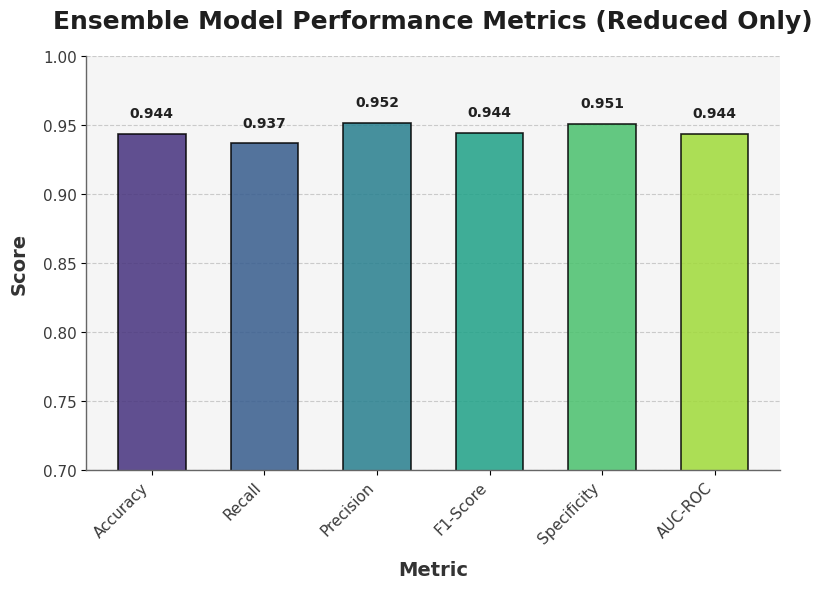

In [84]:
metrics = ["Accuracy", "Recall", "Precision", "F1-Score", "Specificity", "AUC-ROC"]
scores = [T3R_ACCURACY, T3R_RECALL, T3R_PRECISION, T3R_F1, T3R_SPECIFICITY, T3R_ROC_AUC]
colors = sns.color_palette("viridis", len(metrics))  # Use Viridis for a modern gradient

plt.figure(figsize=(8, 6))  

bars = plt.bar(
    metrics, 
    scores, 
    color=colors, 
    edgecolor="black", 
    linewidth=1.2, 
    alpha=0.85,  
    width=0.6
)

for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2, 
        height + 0.01, 
        f"{height:.3f}", 
        ha="center", 
        va="bottom", 
        fontsize=10, 
        fontweight="bold", 
        color="#212121"
    )

plt.title("Ensemble Model Performance Metrics (Reduced Only)", fontsize=18, weight='bold', color="#1E1E1E", pad=20)
plt.xlabel("Metric", fontsize=14, labelpad=10, weight='bold', color="#333333")
plt.ylabel("Score", fontsize=14, labelpad=10, weight='bold', color="#333333")

plt.xticks(fontsize=11, color="#3A3A3A", fontweight="medium", rotation=45, ha="right")
plt.yticks(fontsize=11, color="#3A3A3A", fontweight="medium")

plt.grid(axis="y", linestyle="--", alpha=0.5, color="#A0A0A0")

plt.gca().patch.set_facecolor("#F5F5F5")
plt.gca().patch.set_alpha(1)
plt.gca().set_axisbelow(True)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_linewidth(1.0)
plt.gca().spines['bottom'].set_linewidth(1.0)
plt.gca().spines['left'].set_color("#666666")
plt.gca().spines['bottom'].set_color("#666666")

plt.ylim(0.7, 1.0)
plt.tight_layout()
plt.show()


In [85]:
def compute_metrics_and_append(model_name, y_true, y_pred, results_df):
    TN, FP, FN, TP = confusion_matrix(y_true, y_pred).ravel()
    specificity = TN / (TN + FP)
    auc_roc = roc_auc_score(y_true, y_pred)
    
    results_df = results_df._append({
        "Model": model_name,
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
        "F1-Score": f1_score(y_true, y_pred),
        "Specificity": specificity,
        "AUC-ROC": auc_roc
    }, ignore_index=True)
    
    return results_df


In [86]:
ENSEMBLE_RESULTS = pd.DataFrame(columns=[
    "Model", "Accuracy", "Precision", "Recall", "F1-Score", "Specificity", "AUC-ROC"
])

ENSEMBLE_RESULTS = compute_metrics_and_append(
    "Top3_Ensemble", y_test, TOP3_LABELED_PREDICTIONS, ENSEMBLE_RESULTS
)

ENSEMBLE_RESULTS = compute_metrics_and_append(
    "Top3_Ensemble_R", y_test, TOP3_LABELED_PREDICTIONS_R, ENSEMBLE_RESULTS
)

ENSEMBLE_RESULTS


Model  Accuracy  Precision    Recall  F1-Score  Specificity  \
0    Top3_Ensemble  0.943548   0.951613  0.936508     0.944      0.95082   
1  Top3_Ensemble_R  0.943548   0.951613  0.936508     0.944      0.95082   

    AUC-ROC  
0  0.943664  
1  0.943664

### FULL SUMMARY OF ALL MODEL METRICS

In [87]:
ALL_MODELS_TESTING_SCORES = pd.concat([MODELS_TESTING_SCORES, ENSEMBLE_RESULTS], axis=0)
ALL_MODELS_TESTING_SCORES

Model  Accuracy  Precision    Recall  F1-Score  Specificity  \
0    LogisticRegression  0.943548   0.911765  0.984127  0.946565     0.901639   
1                   SVC  0.935484   0.936508  0.936508  0.936508     0.934426   
2         XGBClassifier  0.967742   0.953846  0.984127  0.968750     0.950820   
3        LGBMClassifier  0.927419   0.935484  0.920635  0.928000     0.934426   
4      TabNetClassifier  0.911290   0.893939  0.936508  0.914729     0.885246   
0  LogisticRegression_R  0.943548   0.911765  0.984127  0.946565     0.901639   
1                 SVC_R  0.927419   0.935484  0.920635  0.928000     0.934426   
2       XGBClassifier_R  0.967742   0.968254  0.968254  0.968254     0.967213   
3      LGBMClassifier_R  0.959677   0.967742  0.952381  0.960000     0.967213   
0         Top3_Ensemble  0.943548   0.951613  0.936508  0.944000     0.950820   
1       Top3_Ensemble_R  0.943548   0.951613  0.936508  0.944000     0.950820   

    AUC-ROC  
0  0.942883  
1  0.935467  
2  0.967473  
3  0.927531  
4  0.910877  
0  0.942883  
1  0.927531  
2  0.967734  
3  0.959797  
0  0.943664  
1  0.943664

In [88]:
# Save each model
import joblib
joblib.dump(TRAINED_XGB, "trained_xgb_model.pkl")
joblib.dump(TRAINED_LOGREG, "trained_logreg_model.pkl")
joblib.dump(TRAINED_SVM, "trained_svm_model.pkl")
joblib.dump(TRAINED_XGB_R, "trained_xgb_r_model.pkl")
joblib.dump(TRAINED_LOGREG_R, "trained_logreg_r_model.pkl")
joblib.dump(TRAINED_LGBM_R, "trained_lgbm_r_model.pkl")


['trained_lgbm_r_model.pkl']

In [89]:
ensemble_weights = {'weight_xgb': 0.33, 'weight_xgb_r': 0.33, 'weight_logreg_r': 0.33, 'weight_lgbm_r': 0.33}
joblib.dump(ensemble_weights, "ensemble_weights.pkl")

['ensemble_weights.pkl']

### Bar graph for each metric across all models

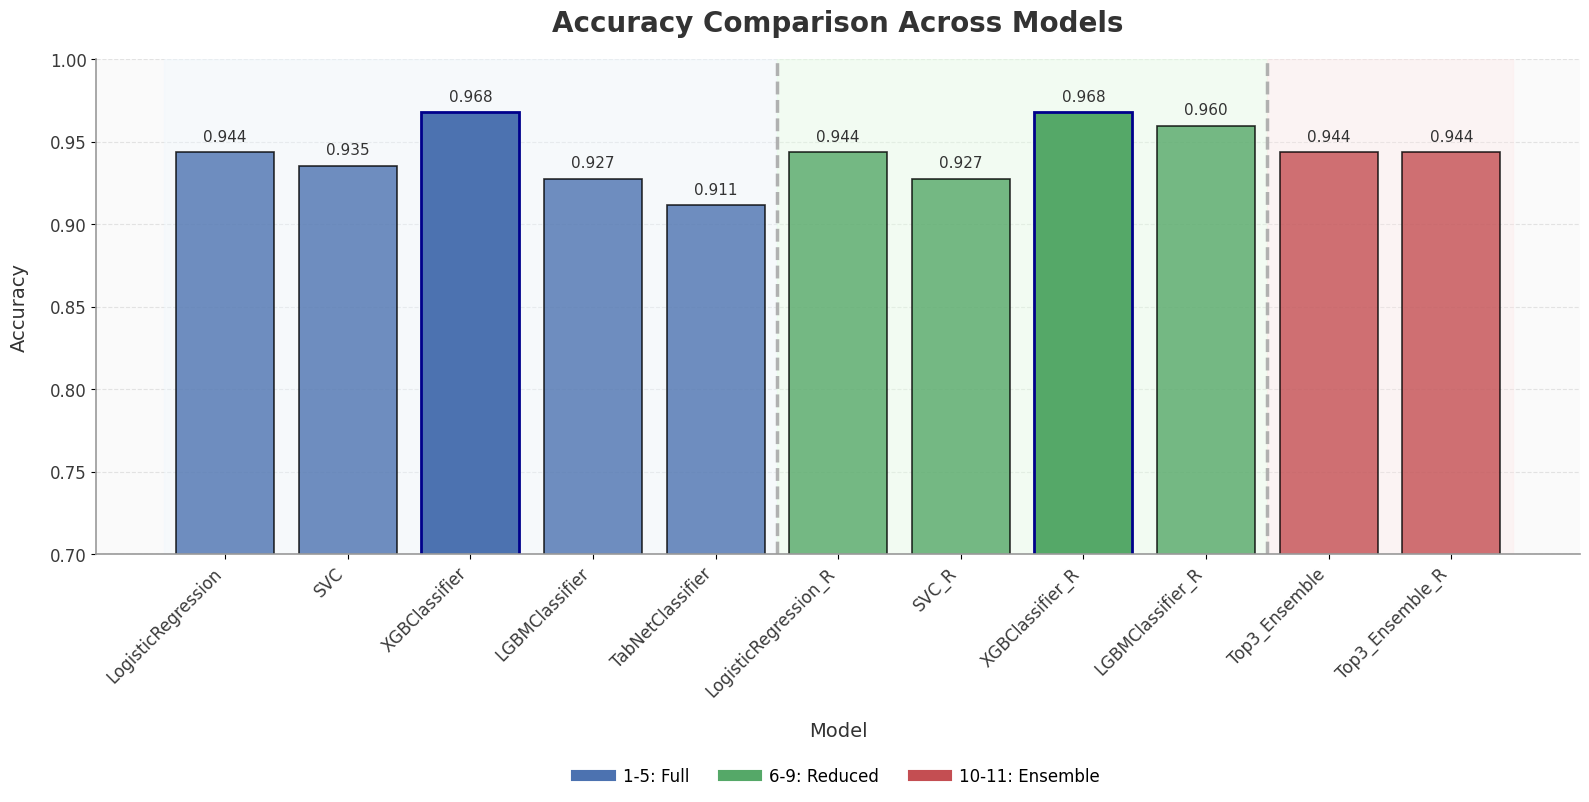

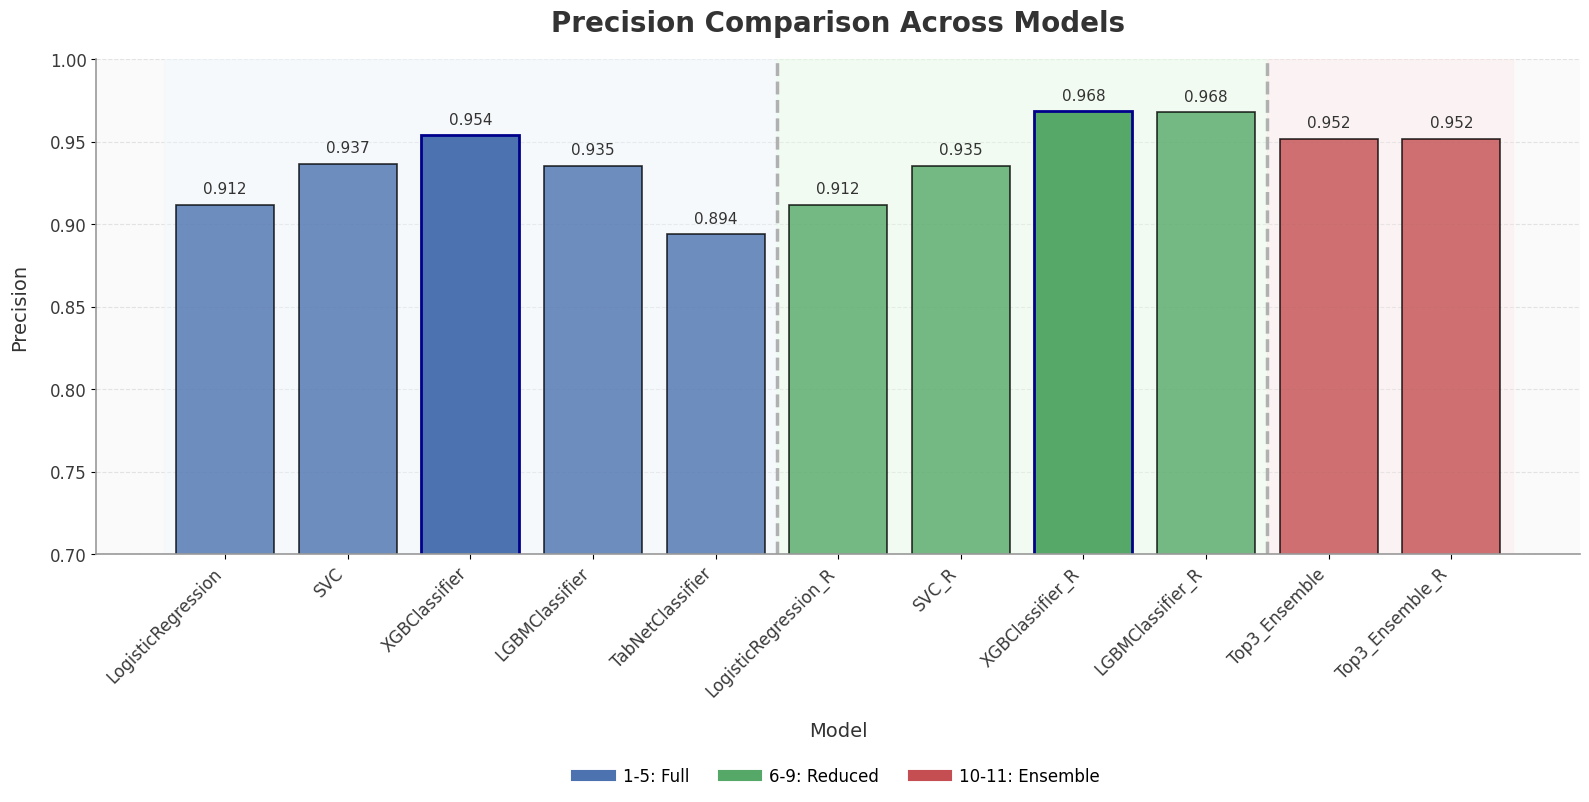

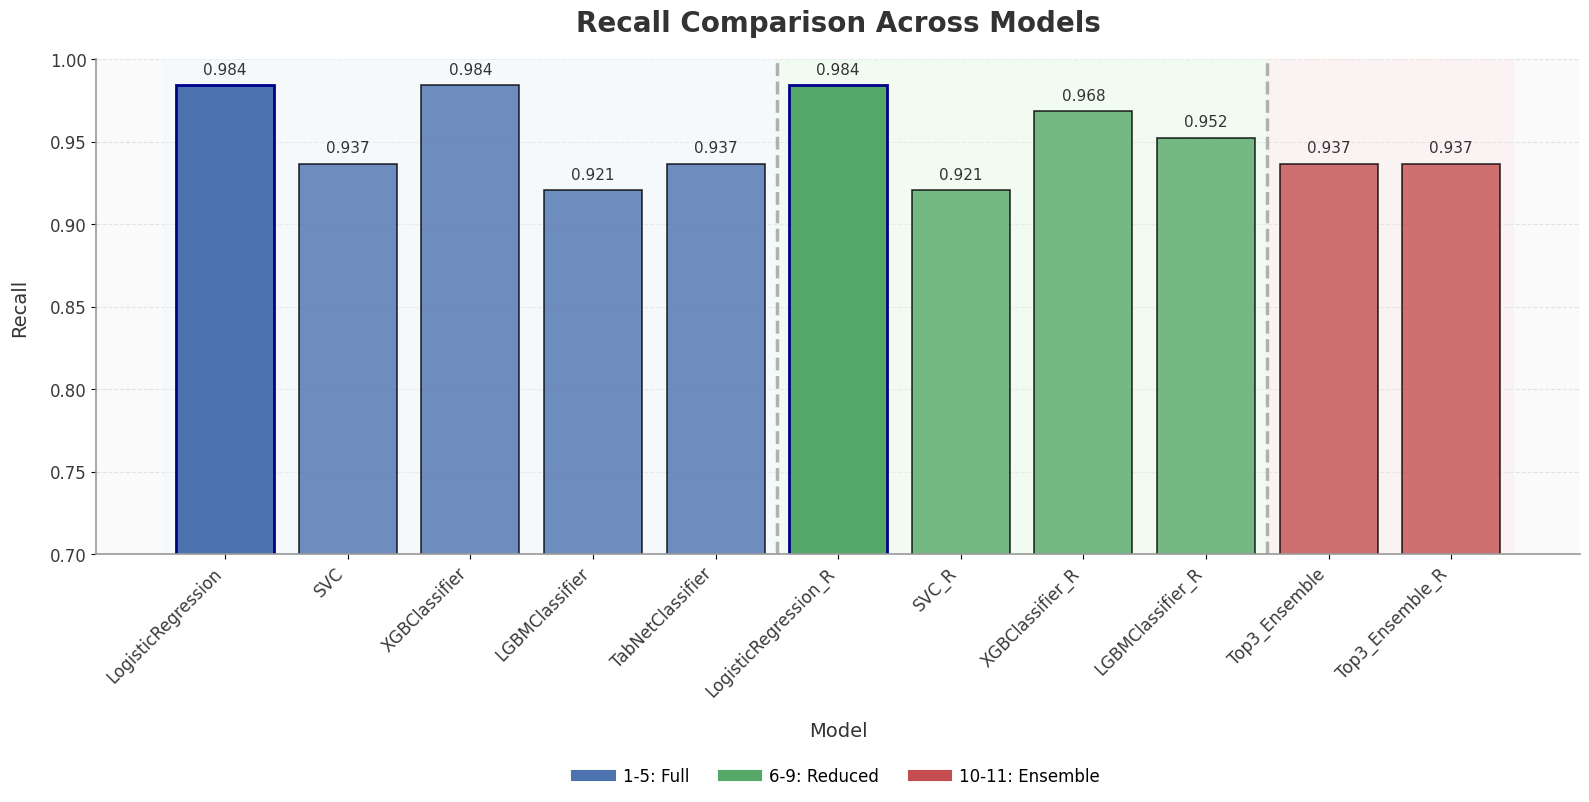

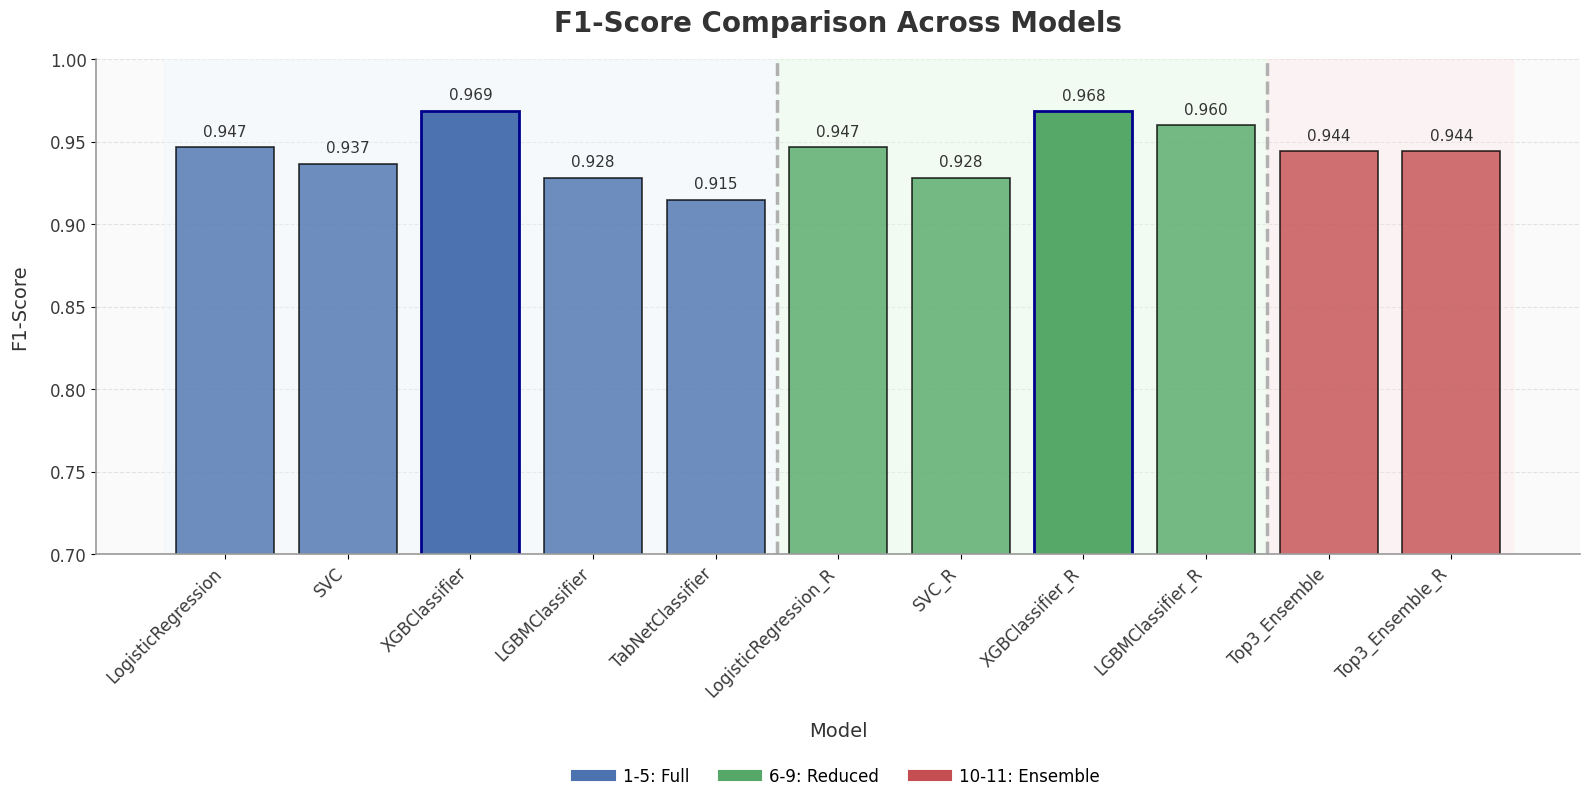

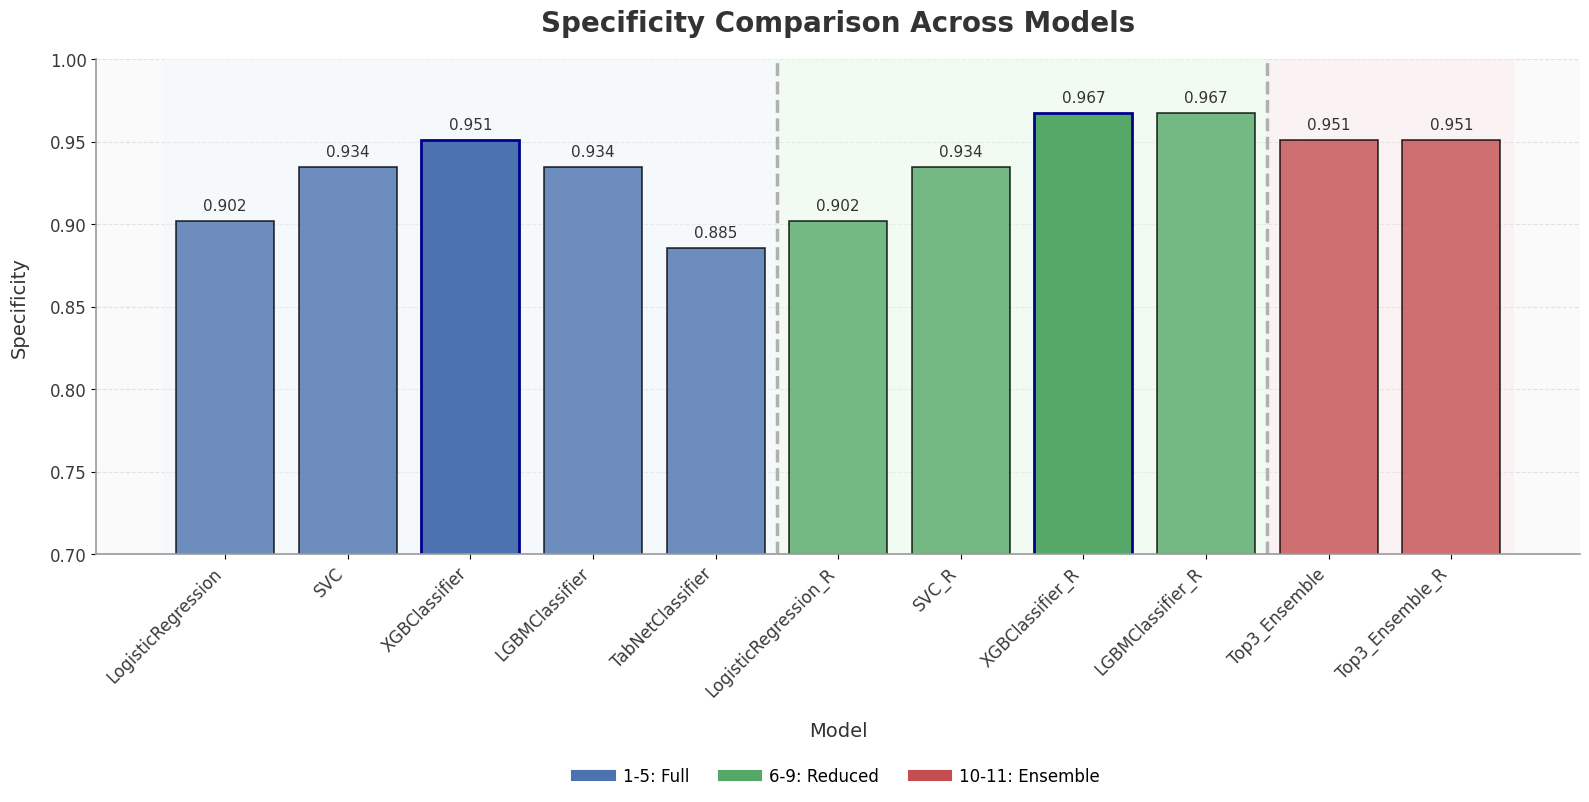

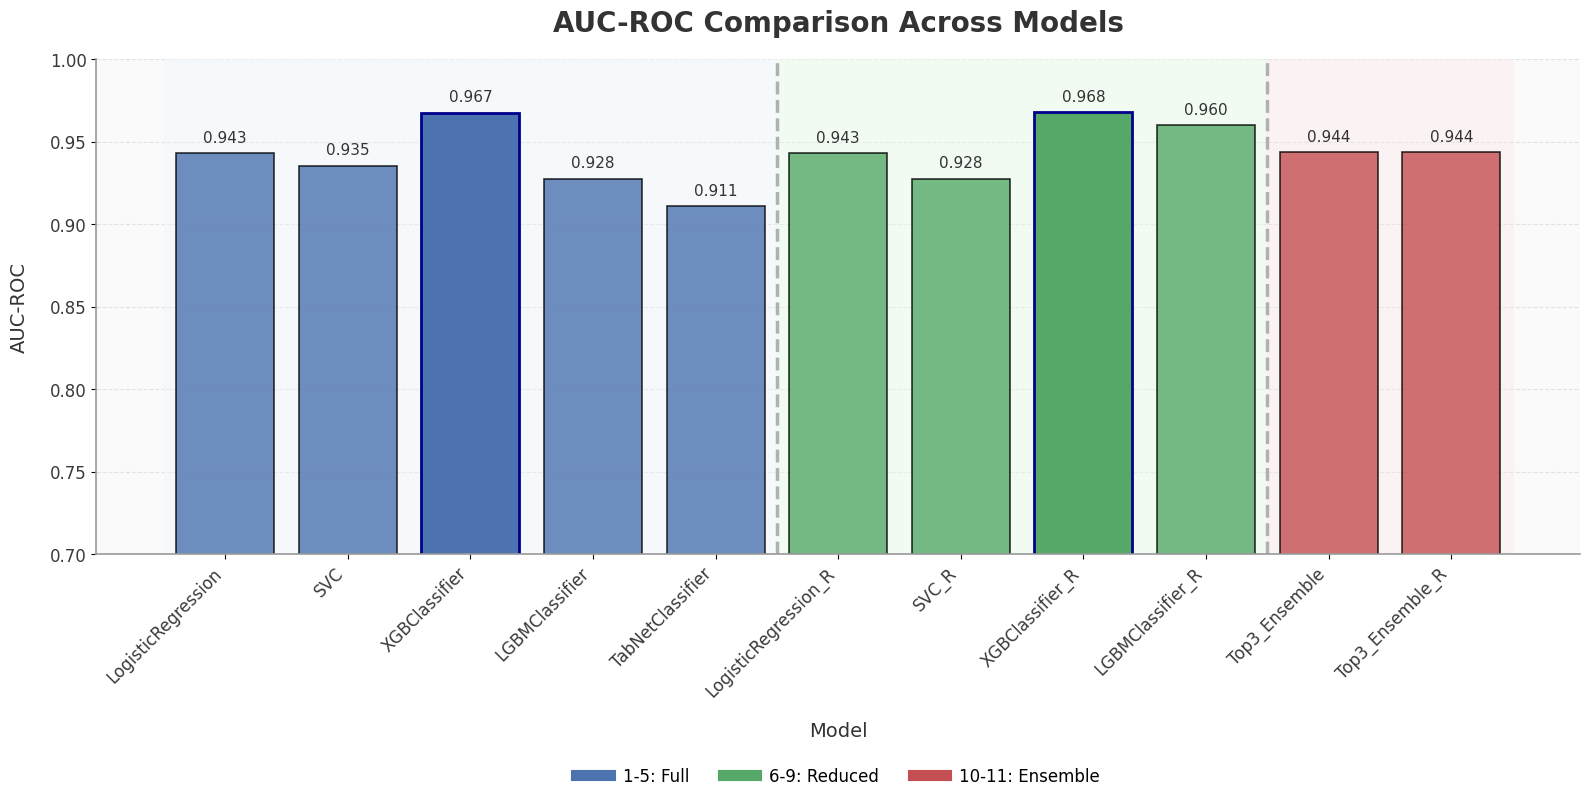

In [98]:
metrics = ["Accuracy", "Precision", "Recall", "F1-Score", "Specificity", "AUC-ROC"]
group_colors = ['#4c72b0', '#55a868', '#c44e52'] 

for i, metric in enumerate(metrics):
    plt.figure(figsize=(16, 8))
    ax = plt.gca()  

    ax.axvspan(-0.5, 4.5, color='#f0f8ff', alpha=0.4)  
    ax.axvspan(4.5, 8.5, color='#e6ffe6', alpha=0.4)  
    ax.axvspan(8.5, len(ALL_MODELS_TESTING_SCORES["Model"]) - 0.5, color='#ffe6e6', alpha=0.3)  

    first_five = ALL_MODELS_TESTING_SCORES[metric][:5]
    six_to_nine = ALL_MODELS_TESTING_SCORES[metric][5:9]

    highest_first_five_idx = first_five.idxmax()
    highest_six_to_nine_idx = six_to_nine.idxmax() + 5 

    bar_colors = (
        [group_colors[0]] * 5 +  # First 5 models
        [group_colors[1]] * 4 +  # Models 6-9
        [group_colors[2]] * 2    # Last 2 models
    )
    
    bars = plt.bar(
        ALL_MODELS_TESTING_SCORES["Model"], 
        ALL_MODELS_TESTING_SCORES[metric], 
        color=bar_colors, 
        edgecolor="black", 
        linewidth=1.2, 
        alpha=0.8
    )

    bars[highest_first_five_idx].set_alpha(1.0)
    bars[highest_first_five_idx].set_edgecolor("darkblue")
    bars[highest_first_five_idx].set_linewidth(2)
    
    bars[highest_six_to_nine_idx].set_alpha(1.0)
    bars[highest_six_to_nine_idx].set_edgecolor("darkblue")
    bars[highest_six_to_nine_idx].set_linewidth(2)

    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2, 
            height + 0.005, 
            f"{height:.3f}", 
            ha="center", 
            va="bottom", 
            fontsize=11, 
            fontweight="medium", 
            color="#333333"
        )

    plt.axvline(x=4.5, color='darkgray', linestyle='dashed', linewidth=2.5, alpha=0.9)
    plt.axvline(x=8.5, color='darkgray', linestyle='dashed', linewidth=2.5, alpha=0.9)
    
    plt.title(f"{metric} Comparison Across Models", fontsize=20, weight='bold', color="#333333", pad=20)
    plt.xlabel("Model", fontsize=14, labelpad=15, weight='medium', color="#333333")
    plt.ylabel(metric, fontsize=14, labelpad=15, weight='medium', color="#333333")
    
    plt.xticks(rotation=45, ha="right", fontsize=12, color="#3A3A3A", fontweight="medium")
    plt.yticks(fontsize=12, color="#3A3A3A", fontweight="medium")
    
    plt.grid(axis="y", linestyle="--", alpha=0.5, color="#CCCCCC")
    
    plt.gca().patch.set_facecolor("#FAFAFA")
    plt.gca().patch.set_alpha(1)
    plt.gca().set_axisbelow(True)
    
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['left'].set_linewidth(1.2)
    plt.gca().spines['bottom'].set_linewidth(1.2)
    plt.gca().spines['left'].set_color("#999999")
    plt.gca().spines['bottom'].set_color("#999999")
    
    plt.ylim(0.7, 1.0)
    
    plt.legend(
        handles=[
            plt.Line2D([0], [0], color=group_colors[0], lw=8, label='1-5: Full'),
            plt.Line2D([0], [0], color=group_colors[1], lw=8, label='6-9: Reduced'),
            plt.Line2D([0], [0], color=group_colors[2], lw=8, label='10-11: Ensemble')
        ],
        loc='upper center',
        bbox_to_anchor=(0.5, -0.4), 
        ncol=3,
        fontsize=12,
        frameon=False
    )

    plt.tight_layout()
    plt.subplots_adjust(bottom=0.3)
    plt.show()
